In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import sys
import time
import tqdm

import numpy as np
import pandas as pd

import pickle

import string
import re
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.util import ngrams
from nltk import word_tokenize

from TurkishStemmer import TurkishStemmer
from zeyrek import MorphAnalyzer
from zemberek import TurkishSpellChecker
from zemberek import TurkishSentenceNormalizer
from zemberek import TurkishSentenceExtractor
from zemberek import TurkishMorphology
from zemberek import TurkishTokenizer
from kisaltmalar import kisaltmalar

from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from simpletransformers.classification import ClassificationModel

import fasttext

import gensim
from gensim import corpora, models, similarities
import pyLDAvis.gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, preprocessing

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

2024-05-18 22:18:06,868 - datasets - INFO
Msg: PyTorch version 2.0.1 available.

2024-05-18 22:18:06,871 - datasets - INFO
Msg: TensorFlow version 2.13.0 available.

2024-05-18 22:18:06,873 - datasets - INFO
Msg: JAX version 0.4.26 available.



/home/alper/.local/lib/python3.10/site-packages/scikitplot/plotters.py:33: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  warnings.warn("This module was deprecated in version 0.3.0 and its functions "


In [ ]:
df = pd.read_csv("/mnt/d/datasets/TurkishTweets.csv")
df.head()

In [ ]:
df.shape

In [ ]:
df["Etiket"].replace({"kızgın": "Negative", "korku": "Negative", "mutlu": "Positive", 
                        "surpriz": "Positive", "üzgün": "Negative"}, inplace=True)
df['Etiket'].unique()

In [ ]:
df = df.groupby('Etiket').apply(lambda x: x.sample(n=500, random_state=1))
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

# Text Preprocessing

In [ ]:
def convert_abbrev(word):
    return kisaltmalar[word] if word in kisaltmalar.keys() else word


def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text
# remove html remains

In [ ]:
# Türkçe kısaltmalar ana sözcüklere çevrilecek
df["Tweets Cleaned"] = df["Tweet"].apply(convert_abbrev_in_text)

In [ ]:
# Tüm kelimeleri küçük harflere çevirme.
df['Tweets Cleaned'] = [token.lower() for token in df['Tweet']]

In [ ]:
# Metinden linkleri temizleme.
df['Tweets Cleaned'] = df['Tweets Cleaned'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [ ]:
# Metinden rakamları temizleme.
df['Tweets Cleaned'] = df['Tweets Cleaned'].apply(lambda x: re.sub('[0-9]+', '', x))

In [ ]:
# Metinden noktalama işaretlerini temizleme.
df['Tweets Cleaned'] = df['Tweets Cleaned'].apply(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
df['Tweets Cleaned'] = df['Tweets Cleaned'].apply(lambda x: x.replace('"', '').replace("’", '').replace("'", '').replace("”", ''))

In [ ]:
# Metinden email'leri temizleme.
df['Tweets Cleaned'] = df['Tweets Cleaned'].apply(lambda x: re.sub('\S*@\S*\s?', '', x))

In [ ]:
# Metinden emojileri temizleme.
df['Tweets Cleaned'] = df['Tweets Cleaned'].apply(lambda x: emoji.replace_emoji(x))

In [ ]:
# Metinden HTML etiketlerini temizleme.
df['Tweets Cleaned'] = df['Tweets Cleaned'].apply(lambda x: re.sub('<.*?>', '', x))

In [ ]:
stop_words = [x.strip() for x in open('/mnt/d/Datasets/stop-words.txt','r', encoding="UTF8").read().split('\n')]

In [ ]:
df['Tweets Cleaned'] = df['Tweets Cleaned'].apply(lambda text: ' '.join([word for word in text.split() if word.lower() not in stop_words]))

In [ ]:
df.sample(5)

In [ ]:
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)
extractor = TurkishSentenceExtractor()
analyzer = MorphAnalyzer()
stemmer = TurkishStemmer()

# Sentence Normalization

In [ ]:
def normalize_long_text(text):
    text = [word for word in text.split()]
    normalized_sentences = [normalizer.normalize(word) for word in text]
    normalized_text = " ".join(normalized_sentences)
    return normalized_text

In [ ]:
df["Sentence Normalization"] = df["Tweets Cleaned"].apply(normalize_long_text)

# Lemmatization

In [ ]:
def lemmatize_text(text):
    text = [word for word in text.split()]
    lemmatized_sent = []
    for word in text:
        if word == '':
            continue
        else:
            lem_word = analyzer.lemmatize(word)
            lemmatized_sent.append(lem_word[0][1][0])

    return " ".join([word.lower() for word in lemmatized_sent])

In [ ]:
df["Lemmatization"] = df["Sentence Normalization"].apply(lemmatize_text)

In [ ]:
df.head()

# Stemming

In [ ]:
def stem_text(text):
    text = [word for word in text.split()]
    stemmed_sent = []
    for word in text:
        if word == '':
            continue
        else:
            stem_word = stemmer.stem(word)
            stemmed_sent.append(stem_word)

    return " ".join([word.lower() for word in stemmed_sent])

In [ ]:
df["Stemming"] = df["Sentence Normalization"].apply(stem_text)

In [ ]:
df.head()

# Remove Rare Words

In [ ]:
freq = pd.Series(' '.join(df['Lemmatization']).split()).value_counts()
less_freq = list(freq[freq == 1].index)

In [ ]:
df['Lemmatization'] = df['Lemmatization'].apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))

In [ ]:
df.head()

In [ ]:
freq = pd.Series(' '.join(df['Stemming']).split()).value_counts()
less_freq = list(freq[freq == 1].index)

In [ ]:
df['Stemming'] = df['Stemming'].apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))

In [ ]:
df.head()

In [ ]:
def word_distribution(text):
    text_arr = [word for word in text.split(" ")]
    word_dict = dict()
    word_dict.fromkeys(set(text_arr))
    for i in set(text_arr):
        word_dict[i] = text.count(i)
    return word_dict

In [ ]:
df["Word Distribution"] = df["Tweet"].apply(word_distribution)

In [ ]:
df.head()

In [ ]:
def word_length_distribution(text):
    text_arr = [len(word) for word in text.split(" ")]
    word_len_dict = dict()
    word_len_dict.fromkeys(range(1, 29))
    for i in range(0, 29):
        word_len_dict[i] = text_arr.count(i)
    return word_len_dict

In [ ]:
df["Word Length Distribution"] = df["Tweet"].apply(word_length_distribution)

In [ ]:
df.head()

In [ ]:
def sentence_length_distribution(text):
    text_arr = [len(sentence) for sentence in extractor.from_paragraph(text)]
    sent_len_dict = dict()
    sent_len_dict.fromkeys(set(text_arr))
    for sent_len in set(text_arr):
        sent_len_dict[sent_len] = text_arr.count(sent_len)
    return sent_len_dict

In [ ]:
df["Sentence Length Distribution"] = df["Tweet"].apply(sentence_length_distribution)

In [ ]:
df.head()

In [ ]:
def average_word_distribution(text):
    text_arr = [word for word in text.split(" ")]
    word_dict = dict()
    word_dict.fromkeys(set(text_arr))
    for i in set(text_arr):
        word_dict[i] = round(text.count(i) / len(text_arr), 4)
    return word_dict

In [ ]:
df["Average Word Distribution"] = df["Tweet"].apply(average_word_distribution)

In [ ]:
df.head()

In [ ]:
def average_word_length_distribution(text):
    text_arr = [sentence for sentence in extractor.from_paragraph(text)]
    aw_len_dict = dict()
    aw_len_dict.fromkeys(text_arr)
    for text in text_arr:
        word_arr = [len(word) for word in text.split(" ")]
        aw_len_dict[text] = round(sum(word_arr) / len(word_arr), 4)

    return aw_len_dict

In [ ]:
df["Average Word Length Distribution"] = df["Tweets Cleaned"].apply(average_word_length_distribution)

In [ ]:
df.head()

In [ ]:
def sentence_punctuation_count(text):
    text_arr = [sentence for sentence in extractor.from_paragraph(text)]
    spc_dict = dict()
    spc_dict.fromkeys(text_arr)
    for text in text_arr:
        spc_dict[text] = len([x for x in text if x in string.punctuation])

    return spc_dict

In [ ]:
df["Sentence Punctuation Count"] = df["Tweet"].apply(sentence_punctuation_count)

In [ ]:
df.head()

In [ ]:
def sentence_stopword_count(text):
    text_arr = [sentence for sentence in extractor.from_paragraph(text)]
    ssc_dict = dict()
    ssc_dict.fromkeys(text_arr)
    for text in text_arr:
        ssc_dict[text] = len([word for word in text.split() if word.lower() not in stop_words])

    return ssc_dict

In [ ]:
df["Sentence Stopword Count"] = df["Tweet"].apply(sentence_stopword_count)

In [ ]:
df.head()

# Named Entity Recognition

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("savasy/bert-base-turkish-ner-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-ner-cased")

In [ ]:
ner = pipeline("ner", model=model, tokenizer=tokenizer)

In [ ]:
def find_ner(text):
    text_arr = [sentence for sentence in extractor.from_paragraph(text)]
    ner_dict = dict()
    ner_dict.fromkeys(text_arr)
    for text in text_arr:
        ner_dict[text] = ner(text)

    return ner_dict

In [ ]:
df["Named Entity Recognition"] = df["Tweet"].apply(find_ner)

In [ ]:
df.head()

In [ ]:
df.to_csv("processed.csv", index=None)

# Data Visualization

In [ ]:
# WordCloud
# En sık geçen kelimeler: uni-gram, bi-gram, tri-gram

In [ ]:
def print_wordcloud(label):
    tokens = ''
    for token in df[df["Etiket"] == label]["Lemmatization"]:
        tokens += token

    wordcloud = WordCloud(background_color="white", width=1200, height=800).generate(tokens)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"{label} - Word Cloud")
    plt.show()

In [ ]:
print_wordcloud("Positive")

In [ ]:
print_wordcloud("Negative")

# N-Grams

In [ ]:
def count_ngrams(corpus, ngram, n):
    vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
def plot_ngrams(ngram_df, ngram_name):
    plt.figure(figsize=(12, 6))
    plt.bar(data=ngram_df, x="Tweets", height="Count")
    plt.xticks(rotation=90)
    plt.xlabel(ngram_name)
    plt.ylabel("Count")
    plt.title(ngram_name)
    plt.show()

In [ ]:
unigrams = count_ngrams(corpus=df["Lemmatization"], ngram=1, n=30)
top_unigram = pd.DataFrame(unigrams, columns=['Tweets', "Count"])
top_unigram.head()

In [ ]:
plot_ngrams(top_unigram, "Unigrams")

In [ ]:
bigrams = count_ngrams(df["Lemmatization"], 2, 30)
top_bigram = pd.DataFrame(bigrams, columns=['Tweets', "Count"])
top_bigram.head()

In [ ]:
plot_ngrams(top_bigram, "Bigrams")

In [ ]:
trigrams = count_ngrams(df["Lemmatization"], 3, 30)
top_trigram = pd.DataFrame(trigrams, columns=['Tweets', "Count"])
top_trigram.head()

In [ ]:
plot_ngrams(top_trigram, "Trigrams")

# Topic Modeling with LDA (Latent Discriminant Analysis)

In [ ]:
tokenized = df["Lemmatization"]
tokenized = [token.split(" ") for token in tokenized]
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized]

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 8, id2word=dictionary, passes=15)
ldamodel.save('lda_model.gensim') 
topics = ldamodel.print_topics(num_words=30) 

In [ ]:
lda_viz = gensim.models.ldamodel.LdaModel.load('lda_model.gensim')#lda modelini yükledik
lda_display = pyLDAvis.gensim.prepare(lda_viz, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

In [ ]:
def dominant_topic(ldamodel,corpus,content):
     sent_topics_df = pd.DataFrame(columns=["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]) 
     for i, row in enumerate(ldamodel[corpus]):
         row = sorted(row, key=lambda x: (x[1]), reverse=True)
         for j, (topic_num, prop_topic) in enumerate(row):
             if j == 0:
                 wp = ldamodel.show_topic(topic_num,topn=30)
                 topic_keywords = ", ".join([word for word, prop in wp])
                 sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,4), topic_keywords]
             else:
                 break
     contents = pd.Series(content)
     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
     return(sent_topics_df)

In [ ]:
df_dominant_topic = dominant_topic(ldamodel=ldamodel, corpus=corpus, content=df['Lemmatization']) 

In [ ]:
df_dominant_topic.head()

# Modelleme

In [ ]:
# TFIDF + ML
# CV + ML
# glove + DL
# word2vec + DL
# own word2vec + DL
# BERT

In [2]:
df = pd.read_csv("processed.csv", usecols=["Tweets Cleaned", "Etiket"])
df.columns = ["label", "text"]
df.head()

,label,text
0,Positive,şok saatir şeyma storysinde birşeyler paylaşma...
1,Negative,endişe verici sakinlik içinden çıkmak istemediğim
2,Positive,seni seviyorum diyenin sevgisinden şüphe et aş...
3,Negative,burun kanamasıyla uyanıyorum delireceğim
4,Positive,canım çekmedi yediğim şey


In [3]:
X = df["text"]
y = df["label"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
le = LabelEncoder()

In [6]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [7]:
le.classes_

array(['Negative', 'Positive'], dtype=object)

In [8]:
tfidf = TfidfVectorizer()

In [9]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
cv = CountVectorizer()

In [11]:
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [12]:
tokenizer = preprocessing.text.Tokenizer(num_words=10000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [13]:
word_index = tokenizer.word_index
len(word_index)

3785

In [14]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_test_tokenizer = tokenizer.texts_to_sequences(X_test)

In [15]:
num_tokens = [len(tokens) for tokens in X_train_tokenizer + X_test_tokenizer]
num_tokens = np.array(num_tokens)
maxlen = int(np.mean(num_tokens) + (2 * np.std(num_tokens)))
print(maxlen)

11


In [16]:
X_train_tokenizer = preprocessing.sequence.pad_sequences(X_train_tokenizer, maxlen=maxlen)
X_test_tokenizer = preprocessing.sequence.pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [17]:
input_dim = len(tokenizer.word_index) + 1
input_dim

3786

In [18]:
embeddings_index = {}
f = open("/mnt/d/Datasets/glove.twitter.27B.100d.txt", "r", encoding="utf-8")
for line in tqdm.tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs

f.close()
print("Found %s word vectors." % len(embeddings_index))

1193514it [00:41, 28752.57it/s]

Found 1193514 word vectors.


In [19]:
embedding_matrix = np.zeros((input_dim, 100))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 3785/3785 [00:00<00:00, 678118.86it/s]


In [20]:
df["labels"] = df["label"].apply(lambda label: dict(zip(le.classes_, le.transform(le.classes_)))[label])

In [21]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=y)

In [22]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [23]:
train_df["label_format"] = 0
for i in range(len(train_df)):
    train_df.label_format[i] = "__label__" + str(train_df.label[i]) + " " + str(train_df.text[i])

/tmp/ipykernel_1765/2340183616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.label_format[i] = "__label__" + str(train_df.label[i]) + " " + str(train_df.text[i])


In [24]:
test_df["label_format"] = 0
for i in range(len(test_df)):
    test_df.label_format[i] = "__label__" + str(test_df.label[i]) + " " + str(test_df.text[i])

/tmp/ipykernel_1765/1283645680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.label_format[i] = "__label__" + str(test_df.label[i]) + " " + str(test_df.text[i])


In [25]:
train_df.label_format.to_csv("fasttext_train.txt", index=None, header=None)

In [26]:
test_df.label_format.to_csv("fasttext_test.txt", index=None, header=None)

In [27]:
documents = [_text.split() for _text in train_df.text]

In [28]:
w2v_model = gensim.models.word2vec.Word2Vec(
    vector_size = 100,
    window = 2,
    min_count = 10,
    workers = 10
)

2024-04-21 17:13:31,867 - gensim.utils - INFO
Msg: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2024-04-21T17:13:31.867570', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'created'}



In [29]:
w2v_model.build_vocab(documents)

2024-04-21 17:13:31,901 - gensim.models.word2vec - INFO
Msg: collecting all words and their counts

2024-04-21 17:13:31,902 - gensim.models.word2vec - INFO
Msg: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types

2024-04-21 17:13:31,904 - gensim.models.word2vec - INFO
Msg: collected 3164 word types from a corpus of 5237 raw words and 800 sentences

2024-04-21 17:13:31,904 - gensim.models.word2vec - INFO
Msg: Creating a fresh vocabulary

2024-04-21 17:13:31,906 - gensim.utils - INFO
Msg: Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 57 unique words (1.80% of original 3164, drops 3107)', 'datetime': '2024-04-21T17:13:31.906142', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}

2024-04-21 17:13:31,906 - gensim.utils - INFO
Msg: Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 897 word corpus (17.13% of o

In [30]:
vocab_len =len(w2v_model.wv)
vocab_len

57

In [31]:
w2v_model.train(documents, total_examples=len(documents), epochs=16)

2024-04-21 17:13:31,950 - gensim.utils - INFO
Msg: Word2Vec lifecycle event {'msg': 'training model with 10 workers on 57 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=2 shrink_windows=True', 'datetime': '2024-04-21T17:13:31.950350', 'gensim': '4.3.2', 'python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'train'}

2024-04-21 17:13:31,956 - gensim.models.word2vec - INFO
Msg: EPOCH 0: training on 5237 raw words (261 effective words) took 0.0s, 276020 effective words/s

2024-04-21 17:13:31,959 - gensim.models.word2vec - INFO
Msg: EPOCH 1: training on 5237 raw words (250 effective words) took 0.0s, 297834 effective words/s

2024-04-21 17:13:31,963 - gensim.models.word2vec - INFO
Msg: EPOCH 2: training on 5237 raw words (260 effective words) took 0.0s, 327691 effective words/s

2024-04-21 17:13:31,966 - gensim.models.word2vec - INFO
Msg: EPOCH 3: training on 5237 r

(4146, 83792)

In [32]:
wv_embedding_matrix = np.zeros((input_dim, 100))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    if word in w2v_model.wv:
        wv_embedding_matrix[i] = w2v_model.wv[word]

100%|██████████| 3785/3785 [00:00<00:00, 1436431.47it/s]


# Machine Learning Models

### TFIDF - MultinomialNB

In [33]:
mnb = MultinomialNB()
mnb_tfidf_train_start = time.time()
mnb.fit(X_train_tfidf, y_train)
mnb_tfidf_train_time = time.time() - mnb_tfidf_train_start
print(f"TFIDF + MultnomialNB Train Time = {mnb_tfidf_train_time:.4f}")

TFIDF + MultnomialNB Train Time = 0.0028


In [34]:
mnb_tfidf_pred_train = mnb.predict(X_train_tfidf)
mnb_tfidf_test_start = time.time()
mnb_tfidf_pred_test = mnb.predict(X_test_tfidf)
mnb_tfidf_test_time = time.time() - mnb_tfidf_test_start

mnb_tfidf_train_score = accuracy_score(mnb_tfidf_pred_train, y_train)
mnb_tfidf_test_score = accuracy_score(mnb_tfidf_pred_test, y_test)
print(f"TFIDF + MultinomialNB Train Score = {mnb_tfidf_train_score * 100:.4f}%")
print(f"TFIDF + MultinomialNB Test Score = {mnb_tfidf_test_score * 100:.4f}%")
print(f"TFIDF + MultinomialNB Test Time = {mnb_tfidf_test_time:.4f}")

TFIDF + MultinomialNB Train Score = 100.0000%
TFIDF + MultinomialNB Test Score = 91.5000%
TFIDF + MultinomialNB Test Time = 0.0004


In [35]:
mnb_tfidf_precision_score = precision_score(y_test, mnb_tfidf_pred_test, average='weighted')
mnb_tfidf_f1_score = f1_score(y_test, mnb_tfidf_pred_test, average='weighted')
mnb_tfidf_recall_score = recall_score(y_test, mnb_tfidf_pred_test, average='weighted')
mnb_tfidf_accuracy_score = accuracy_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_roc_auc_score = roc_auc_score(y_test, mnb_tfidf_pred_test)

print(f"TFIDF + MultinomialNB Precision Score = {mnb_tfidf_precision_score * 100:.4f}%")
print(f"TFIDF + MultinomialNB F1 Score = {mnb_tfidf_f1_score * 100:.4f}%")
print(f"TFIDF + MultinomialNB Recall Score = {mnb_tfidf_recall_score * 100:.4f}%")
print(f"TFIDF + MultinomialNB Accuracy Score = {mnb_tfidf_accuracy_score * 100:.4f}%")
print(f"TFIDF + MultinomialNB ROC-AUC Score = {mnb_tfidf_roc_auc_score * 100:.4f}%")

TFIDF + MultinomialNB Precision Score = 91.5042%
TFIDF + MultinomialNB F1 Score = 91.4998%
TFIDF + MultinomialNB Recall Score = 91.5000%
TFIDF + MultinomialNB Accuracy Score = 91.5000%
TFIDF + MultinomialNB ROC-AUC Score = 91.5000%


In [36]:
print(classification_report(y_test, mnb_tfidf_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       100
           1       0.92      0.91      0.91       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



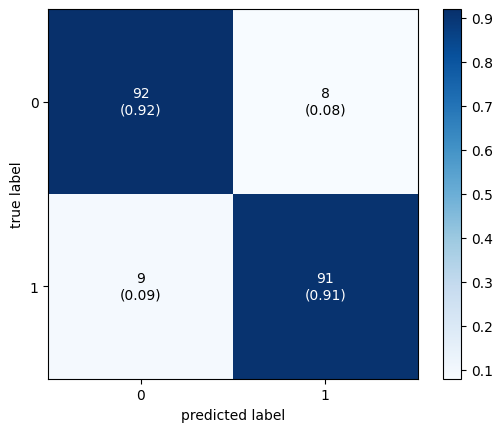

In [37]:
mnb_tfidf_cm = confusion_matrix(y_test, mnb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

### CV + MultinomialNB

In [38]:
mnb = MultinomialNB()
mnb_cv_train_start = time.time()
mnb.fit(X_train_cv, y_train)
mnb_cv_train_time = time.time() - mnb_cv_train_start
print(f"CV + MultinomialNB Train Time = {mnb_cv_train_time:.4f}")

CV + MultinomialNB Train Time = 0.0021


In [39]:
mnb_cv_pred_train = mnb.predict(X_train_cv)
mnb_cv_test_start = time.time()
mnb_cv_pred_test = mnb.predict(X_test_cv)
mnb_cv_test_time = time.time() - mnb_cv_test_start

mnb_cv_train_score = accuracy_score(mnb_cv_pred_train, y_train)
mnb_cv_test_score = accuracy_score(mnb_cv_pred_test, y_test)
print(f"CV + MultinomialNB Train Score = {mnb_cv_train_score * 100:.4f}%")
print(f"CV + MultinomialNB Test Score = {mnb_cv_test_score * 100:.4f}%")
print(f"CV + MultinomialNB Test Time = {mnb_cv_test_time:.4f}")

CV + MultinomialNB Train Score = 99.8750%
CV + MultinomialNB Test Score = 92.5000%
CV + MultinomialNB Test Time = 0.0004


In [40]:
mnb_cv_precision_score = precision_score(y_test, mnb_cv_pred_test, average='weighted')
mnb_cv_f1_score = f1_score(y_test, mnb_cv_pred_test, average='weighted')
mnb_cv_recall_score = recall_score(y_test, mnb_cv_pred_test, average='weighted')
mnb_cv_accuracy_score = accuracy_score(y_test, mnb_cv_pred_test)
mnb_cv_roc_auc_score = roc_auc_score(y_test, mnb_cv_pred_test)

print(f"CV + MultinomialNB Precision Score = {mnb_cv_precision_score * 100:.4f}%")
print(f"CV + MultinomialNB F1 Score = {mnb_cv_f1_score * 100:.4f}%")
print(f"CV + MultinomialNB Recall Score = {mnb_cv_recall_score * 100:.4f}%")
print(f"CV + MultinomialNB Accuracy Score = {mnb_cv_accuracy_score * 100:.4f}%")
print(f"CV + MultinomialNB ROC-AUC Score = {mnb_cv_roc_auc_score * 100:.4f}%")

CV + MultinomialNB Precision Score = 92.5043%
CV + MultinomialNB F1 Score = 92.4998%
CV + MultinomialNB Recall Score = 92.5000%
CV + MultinomialNB Accuracy Score = 92.5000%
CV + MultinomialNB ROC-AUC Score = 92.5000%


In [41]:
print(classification_report(y_test, mnb_cv_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       100
           1       0.93      0.92      0.92       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



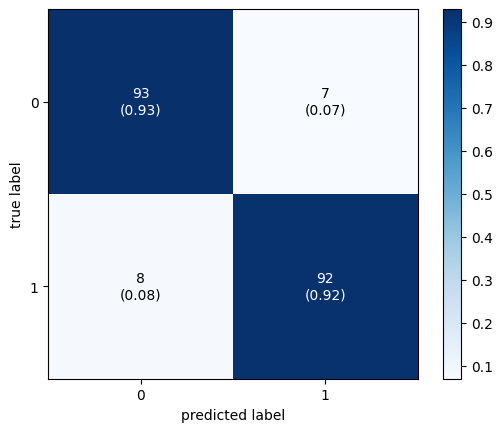

In [42]:
mnb_cv_cm = confusion_matrix(y_test, mnb_cv_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_cv_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

### TFIDF + Random Forest

In [43]:
rf = RandomForestClassifier()
rf_tfidf_train_start = time.time()
rf.fit(X_train_tfidf, y_train)
rf_tfidf_train_time = time.time() - rf_tfidf_train_start
print(f"TFIDF + Random Forest Train Time = {rf_tfidf_train_time:.4f}")

TFIDF + Random Forest Train Time = 0.1671


In [44]:
rf_tfidf_pred_train = rf.predict(X_train_tfidf)
rf_tfidf_test_start = time.time()
rf_tfidf_pred_test = rf.predict(X_test_tfidf)
rf_tfidf_test_time = time.time() - rf_tfidf_test_start

rf_tfidf_train_score = accuracy_score(rf_tfidf_pred_train, y_train)
rf_tfidf_test_score = accuracy_score(rf_tfidf_pred_test, y_test)
print(f"TFIDF + Random Forest Train Score = {rf_tfidf_train_score * 100:.4f}%")
print(f"TFIDF + Random Forest Test Score = {rf_tfidf_test_score * 100:.4f}%")
print(f"TFIDF + Random Forest Test Time = {rf_tfidf_test_time:.4f}")

TFIDF + Random Forest Train Score = 100.0000%
TFIDF + Random Forest Test Score = 92.0000%
TFIDF + Random Forest Test Time = 0.0064


In [45]:
rf_tfidf_precision_score = precision_score(y_test, rf_tfidf_pred_test, average='weighted')
rf_tfidf_f1_score = f1_score(y_test, rf_tfidf_pred_test, average='weighted')
rf_tfidf_recall_score = recall_score(y_test, rf_tfidf_pred_test, average='weighted')
rf_tfidf_accuracy_score = accuracy_score(y_test, rf_tfidf_pred_test)
rf_tfidf_roc_auc_score = roc_auc_score(y_test, rf_tfidf_pred_test)

print(f"TFIDF + Random Forest Precision Score = {rf_tfidf_precision_score * 100:.4f}%")
print(f"TFIDF + Random Forest F1 Score = {rf_tfidf_f1_score * 100:.4f}%")
print(f"TFIDF + Random Forest Recall Score = {rf_tfidf_recall_score * 100:.4f}%")
print(f"TFIDF + Random Forest Accuracy Score = {rf_tfidf_accuracy_score * 100:.4f}%")
print(f"TFIDF + Random Forest ROC-AUC Score = {rf_tfidf_roc_auc_score * 100:.4f}%")

TFIDF + Random Forest Precision Score = 92.4242%
TFIDF + Random Forest F1 Score = 91.9799%
TFIDF + Random Forest Recall Score = 92.0000%
TFIDF + Random Forest Accuracy Score = 92.0000%
TFIDF + Random Forest ROC-AUC Score = 92.0000%


In [46]:
print(classification_report(y_test, rf_tfidf_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       100
           1       0.97      0.87      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



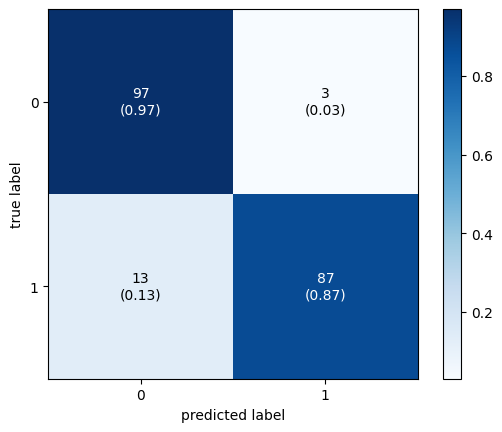

In [47]:
rf_tfidf_cm = confusion_matrix(y_test, rf_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

### CV + Random Forest

In [48]:
rf = RandomForestClassifier()
rf_cv_train_start = time.time()
rf.fit(X_train_cv, y_train)
rf_cv_train_time = time.time() - rf_cv_train_start
print(f"CV + Random Forest Train Time = {rf_cv_train_time:.4f}")

CV + Random Forest Train Time = 0.1535


In [49]:
rf_cv_pred_train = rf.predict(X_train_cv)
rf_cv_test_start = time.time()
rf_cv_pred_test = rf.predict(X_test_cv)
rf_cv_test_time = time.time() - rf_cv_test_start

rf_cv_train_score = accuracy_score(rf_cv_pred_train, y_train)
rf_cv_test_score = accuracy_score(rf_cv_pred_test, y_test)
print(f"CV + Random Forest Train Score = {rf_cv_train_score * 100:.4f}%")
print(f"CV + Random Forest Test Score = {rf_cv_test_score * 100:.4f}%")
print(f"CV + Random Forest Test Time = {rf_cv_test_time:.4f}")

CV + Random Forest Train Score = 100.0000%
CV + Random Forest Test Score = 93.5000%
CV + Random Forest Test Time = 0.0075


In [50]:
rf_cv_precision_score = precision_score(y_test, rf_cv_pred_test, average='weighted')
rf_cv_f1_score = f1_score(y_test, rf_cv_pred_test, average='weighted')
rf_cv_recall_score = recall_score(y_test, rf_cv_pred_test, average='weighted')
rf_cv_accuracy_score = accuracy_score(y_test, rf_cv_pred_test)
rf_cv_roc_auc_score = roc_auc_score(y_test, rf_cv_pred_test)

print(f"CV + Random Forest Precision Score = {rf_cv_precision_score * 100:.4f}%")
print(f"CV + Random Forest F1 Score = {rf_cv_f1_score * 100:.4f}%")
print(f"CV + Random Forest Recall Score = {rf_cv_recall_score * 100:.4f}%")
print(f"CV + Random Forest Accuracy Score = {rf_cv_accuracy_score * 100:.4f}%")
print(f"CV + Random Forest ROC-AUC Score = {rf_cv_roc_auc_score * 100:.4f}%")

CV + Random Forest Precision Score = 93.5044%
CV + Random Forest F1 Score = 93.4998%
CV + Random Forest Recall Score = 93.5000%
CV + Random Forest Accuracy Score = 93.5000%
CV + Random Forest ROC-AUC Score = 93.5000%


In [51]:
print(classification_report(y_test, rf_cv_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       100
           1       0.93      0.94      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



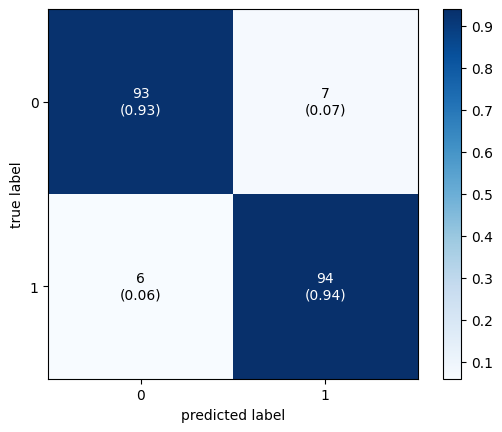

In [52]:
rf_cv_cm = confusion_matrix(y_test, rf_cv_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_cv_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

### TFIDF + XGB

In [53]:
xgb = XGBClassifier()
xgb_tfidf_train_start = time.time()
xgb.fit(X_train_tfidf, y_train)
xgb_tfidf_train_time = time.time() - xgb_tfidf_train_start
print(f"TFIDF + XGB Train Time = {xgb_tfidf_train_time:.4f}")

TFIDF + XGB Train Time = 0.3524


In [54]:
xgb_tfidf_pred_train = xgb.predict(X_train_tfidf)
xgb_tfidf_test_start = time.time()
xgb_tfidf_pred_test = xgb.predict(X_test_tfidf)
xgb_tfidf_test_time = time.time() - xgb_tfidf_test_start

xgb_tfidf_train_score = accuracy_score(xgb_tfidf_pred_train, y_train)
xgb_tfidf_test_score = accuracy_score(xgb_tfidf_pred_test, y_test)
print(f"TFIDF + XGB Train Score = {xgb_tfidf_train_score * 100:.4f}%")
print(f"TFIDF + XGB Test Score = {xgb_tfidf_test_score * 100:.4f}%")
print(f"TFIDF + XGB Test Time = {xgb_tfidf_test_time:.4f}")

TFIDF + XGB Train Score = 91.7500%
TFIDF + XGB Test Score = 84.0000%
TFIDF + XGB Test Time = 0.0008


In [55]:
xgb_tfidf_precision_score = precision_score(y_test, xgb_tfidf_pred_test, average='weighted')
xgb_tfidf_f1_score = f1_score(y_test, xgb_tfidf_pred_test, average='weighted')
xgb_tfidf_recall_score = recall_score(y_test, xgb_tfidf_pred_test, average='weighted')
xgb_tfidf_accuracy_score = accuracy_score(y_test, xgb_tfidf_pred_test)
xgb_tfidf_roc_auc_score = roc_auc_score(y_test, xgb_tfidf_pred_test)

print(f"TFIDF + XGB Precision Score = {xgb_tfidf_precision_score * 100:.4f}%")
print(f"TFIDF + XGB F1 Score = {xgb_tfidf_f1_score * 100:.4f}%")
print(f"TFIDF + XGB Recall Score = {xgb_tfidf_recall_score * 100:.4f}%")
print(f"TFIDF + XGB Accuracy Score = {xgb_tfidf_accuracy_score * 100:.4f}%")
print(f"TFIDF + XGB ROC-AUC Score = {xgb_tfidf_roc_auc_score * 100:.4f}%")

TFIDF + XGB Precision Score = 86.4650%
TFIDF + XGB F1 Score = 83.7250%
TFIDF + XGB Recall Score = 84.0000%
TFIDF + XGB Accuracy Score = 84.0000%
TFIDF + XGB ROC-AUC Score = 84.0000%


In [56]:
print(classification_report(y_test, xgb_tfidf_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       100
           1       0.96      0.71      0.82       100

    accuracy                           0.84       200
   macro avg       0.86      0.84      0.84       200
weighted avg       0.86      0.84      0.84       200



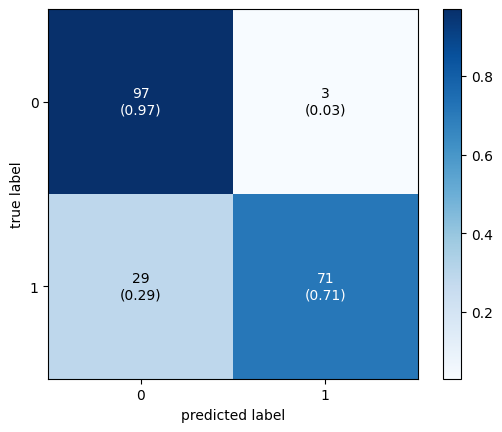

In [57]:
xgb_tfidf_cm = confusion_matrix(y_test, xgb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=xgb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

### CV + XGB

In [58]:
xgb = XGBClassifier()
xgb_cv_train_start = time.time()
xgb.fit(X_train_cv, y_train)
xgb_cv_train_time = time.time() - xgb_cv_train_start
print(f"CV + XGB Train Time = {xgb_cv_train_time:.4f}")

CV + XGB Train Time = 0.0632


In [59]:
xgb_cv_pred_train = xgb.predict(X_train_cv)
xgb_cv_test_start = time.time()
xgb_cv_pred_test = xgb.predict(X_test_cv)
xgb_cv_test_time = time.time() - xgb_cv_test_start

xgb_cv_train_score = accuracy_score(xgb_cv_pred_train, y_train)
xgb_cv_test_score = accuracy_score(xgb_cv_pred_test, y_test)
print(f"CV + XGB Train Score = {xgb_cv_train_score * 100:.4f}%")
print(f"CV + XGB Test Score = {xgb_cv_test_score * 100:.4f}%")
print(f"CV + XGB Test Time = {xgb_cv_test_time:.4f}")

CV + XGB Train Score = 91.3750%
CV + XGB Test Score = 88.0000%
CV + XGB Test Time = 0.0006


In [60]:
xgb_cv_precision_score = precision_score(y_test, xgb_cv_pred_test, average='weighted')
xgb_cv_f1_score = f1_score(y_test, xgb_cv_pred_test, average='weighted')
xgb_cv_recall_score = recall_score(y_test, xgb_cv_pred_test, average='weighted')
xgb_cv_accuracy_score = accuracy_score(y_test, xgb_cv_pred_test)
xgb_cv_roc_auc_score = roc_auc_score(y_test, xgb_cv_pred_test)

print(f"CV + XGB Precision Score = {xgb_cv_precision_score * 100:.4f}%")
print(f"CV + XGB F1 Score = {xgb_cv_f1_score * 100:.4f}%")
print(f"CV + XGB Recall Score = {xgb_cv_recall_score * 100:.4f}%")
print(f"CV + XGB Accuracy Score = {xgb_cv_accuracy_score * 100:.4f}%")
print(f"CV + XGB ROC-AUC Score = {xgb_cv_roc_auc_score * 100:.4f}%")

CV + XGB Precision Score = 89.5833%
CV + XGB F1 Score = 87.8788%
CV + XGB Recall Score = 88.0000%
CV + XGB Accuracy Score = 88.0000%
CV + XGB ROC-AUC Score = 88.0000%


In [61]:
print(classification_report(y_test, xgb_cv_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       100
           1       0.97      0.78      0.87       100

    accuracy                           0.88       200
   macro avg       0.90      0.88      0.88       200
weighted avg       0.90      0.88      0.88       200



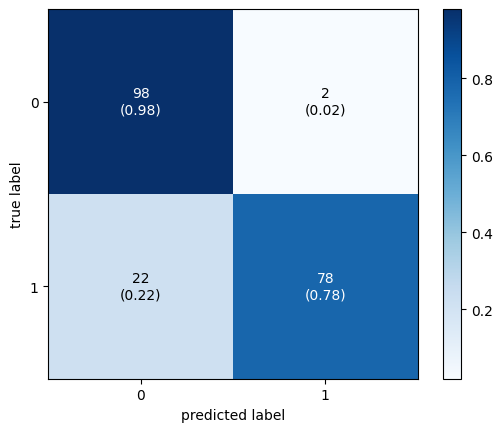

In [62]:
xgb_cv_cm = confusion_matrix(y_test, xgb_cv_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=xgb_cv_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

# Deep Learning Models

### GloVe + SimpleRNN

In [63]:
simplernn = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    layers.SimpleRNN(100),
    layers.Dense(1, activation='sigmoid')
])

simplernn.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])    

simplernn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 100)           378600    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 398801 (1.52 MB)
Trainable params: 20201 (78.91 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [64]:
model1_train_start = time.time()
simplernn_history = simplernn.fit(X_train_tokenizer, 
                                  y_train, 
                                  epochs=25, 
                                  batch_size=64, 
                                  validation_split=0.1, 
                                  callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model1_train_time = time.time() - model1_train_start
print(f"SimpleRNN Train Time = {model1_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 3s 32ms/step - loss: 0.6875 - accuracy: 0.5667 - val_loss: 0.6182 - val_accuracy: 0.6375
Epoch 2/25
12/12 [==============================] - 0s 17ms/step - loss: 0.5393 - accuracy: 0.7208 - val_loss: 0.5583 - val_accuracy: 0.6875
Epoch 3/25
12/12 [==============================] - 0s 17ms/step - loss: 0.4353 - accuracy: 0.8139 - val_loss: 0.5339 - val_accuracy: 0.7750
Epoch 4/25
12/12 [==============================] - 0s 16ms/step - loss: 0.3535 - accuracy: 0.8500 - val_loss: 0.5061 - val_accuracy: 0.7875
Epoch 5/25
12/12 [==============================] - 0s 18ms/step - loss: 0.3065 - accuracy: 0.8819 - val_loss: 0.5061 - val_accuracy: 0.8000
Epoch 6/25
12/12 [==============================] - 0s 17ms/step - loss: 0.2499 - accuracy: 0.9139 - val_loss: 0.5398 - val_accuracy: 0.7750
Epoch 7/25
12/12 [==============================] - 0s 16ms/step - loss: 0.2137 - accuracy: 0.9347 - val_loss: 0.5289 - val_accuracy: 0.8250
Epoch 8/25
12

In [65]:
model1_test_start = time.time()
simplernn_pred_test = simplernn.predict(X_test_tokenizer)
model1_test_time = time.time() - model1_test_start
print(f"SimpleRNN Test Time = {model1_test_time:.4f}")

7/7 [==============================] - 0s 4ms/step
SimpleRNN Test Time = 0.1520


In [66]:
simplernn_pred_train = simplernn.predict(X_train_tokenizer)
simplernn_pred_train = [1 if i > 0.5 else 0 for i in simplernn_pred_train]
simplernn_pred_test = [1 if i > 0.5 else 0 for i in simplernn_pred_test]
simplernn_train_score = accuracy_score(simplernn_pred_train, y_train)
simplernn_test_score = accuracy_score(simplernn_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn_train_score * 100:.4f}%")
print(f"SimpleRNN Test Score = {simplernn_test_score * 100:.4f}%")

25/25 [==============================] - 0s 4ms/step
SimpleRNN Train Score = 96.6250%
SimpleRNN Test Score = 80.0000%


In [67]:
simplernn_precision_score = precision_score(y_test, simplernn_pred_test)
simplernn_f1_score = f1_score(y_test, simplernn_pred_test)
simplernn_recall_score = recall_score(y_test, simplernn_pred_test)
simplernn_accuracy_score = accuracy_score(y_test, simplernn_pred_test)

print(f"SimpleRNN Precision Score = {simplernn_precision_score * 100:.4f}%")
print(f"SimpleRNN F1 Score = {simplernn_f1_score * 100:.4f}%")
print(f"SimpleRNN Recall Score = {simplernn_recall_score * 100:.4f}%")
print(f"SimpleRNN Accuracy Score = {simplernn_accuracy_score * 100:.4f}%")

SimpleRNN Precision Score = 80.0000%
SimpleRNN F1 Score = 80.0000%
SimpleRNN Recall Score = 80.0000%
SimpleRNN Accuracy Score = 80.0000%


In [68]:
print(classification_report(y_test, simplernn_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       100
           1       0.80      0.80      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



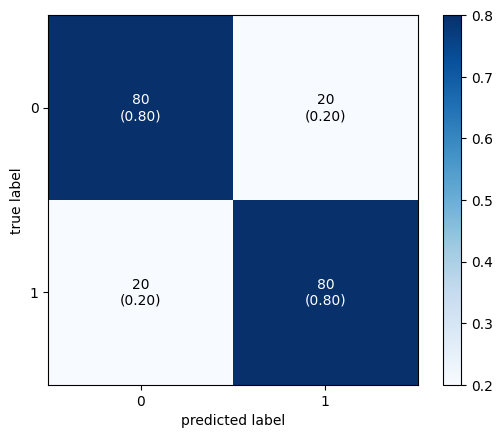

In [69]:
simplernn_cm = confusion_matrix(y_test, simplernn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

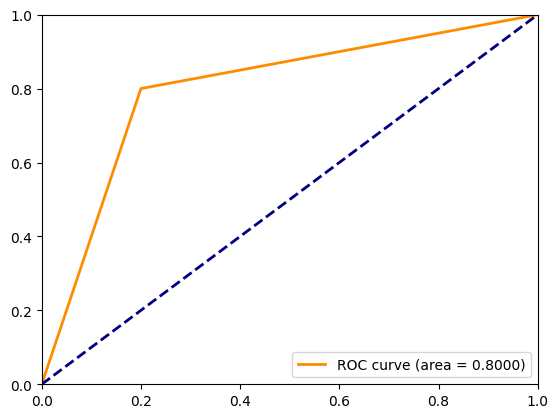

In [70]:
fpr, tpr, _ = roc_curve(y_test, simplernn_pred_test)
simplernn_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {simplernn_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

### GloVe + LSTM

In [71]:
lstm = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    layers.LSTM(100),
    layers.Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 100)           378600    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 459101 (1.75 MB)
Trainable params: 80501 (314.46 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [72]:
model2_train_start = time.time()
lstm_results = lstm.fit(X_train_tokenizer, 
                        y_train, 
                        epochs=25, 
                        batch_size=64, 
                        validation_split=0.1,
                        callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model2_train_time = time.time() - model2_train_start
print(f"LSTM Train Time = {model2_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 2s 33ms/step - loss: 0.6536 - accuracy: 0.6222 - val_loss: 0.6123 - val_accuracy: 0.7250
Epoch 2/25
12/12 [==============================] - 0s 12ms/step - loss: 0.5514 - accuracy: 0.7597 - val_loss: 0.5462 - val_accuracy: 0.6875
Epoch 3/25
12/12 [==============================] - 0s 12ms/step - loss: 0.4534 - accuracy: 0.7986 - val_loss: 0.5049 - val_accuracy: 0.7500
Epoch 4/25
12/12 [==============================] - 0s 10ms/step - loss: 0.3865 - accuracy: 0.8319 - val_loss: 0.4882 - val_accuracy: 0.7625
Epoch 5/25
12/12 [==============================] - 0s 8ms/step - loss: 0.3421 - accuracy: 0.8639 - val_loss: 0.4587 - val_accuracy: 0.8125
Epoch 6/25
12/12 [==============================] - 0s 8ms/step - loss: 0.3069 - accuracy: 0.8819 - val_loss: 0.4955 - val_accuracy: 0.8000
Epoch 7/25
12/12 [==============================] - 0s 8ms/step - loss: 0.2611 - accuracy: 0.9083 - val_loss: 0.4758 - val_accuracy: 0.8125
Epoch 8/25
12/12

In [73]:
model2_test_start = time.time()
lstm_pred_test = lstm.predict(X_test_tokenizer)
model2_test_time = time.time() - model2_test_start
print(f"LSTM Test Time = {model2_test_time:.4f}")

7/7 [==============================] - 0s 2ms/step
LSTM Test Time = 0.2120


In [74]:
lstm_pred_train = lstm.predict(X_train_tokenizer)
lstm_pred_train = [1 if i > 0.5 else 0 for i in lstm_pred_train]
lstm_pred_test = [1 if i > 0.5 else 0 for i in lstm_pred_test]
lstm_train_score = accuracy_score(lstm_pred_train, y_train)
lstm_test_score = accuracy_score(lstm_pred_test, y_test)
print(f"LSTM Train Score = {lstm_train_score * 100:.4f}%")
print(f"LSTM Test Score = {lstm_test_score * 100:.4f}%")

25/25 [==============================] - 0s 3ms/step
LSTM Train Score = 92.8750%
LSTM Test Score = 81.0000%


In [75]:
lstm_precision_score = precision_score(y_test, lstm_pred_test)
lstm_f1_score = f1_score(y_test, lstm_pred_test)
lstm_recall_score = recall_score(y_test, lstm_pred_test)
lstm_accuracy_score = accuracy_score(y_test, lstm_pred_test)

print(f"LSTM Precision Score = {lstm_precision_score * 100:.4f}%")
print(f"LSTM F1 Score = {lstm_f1_score * 100:.4f}%")
print(f"LSTM Recall Score = {lstm_recall_score * 100:.4f}%")
print(f"LSTM Accuracy Score = {lstm_accuracy_score * 100:.4f}%")

LSTM Precision Score = 81.6327%
LSTM F1 Score = 80.8081%
LSTM Recall Score = 80.0000%
LSTM Accuracy Score = 81.0000%


In [76]:
print(classification_report(y_test, lstm_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.82      0.80      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



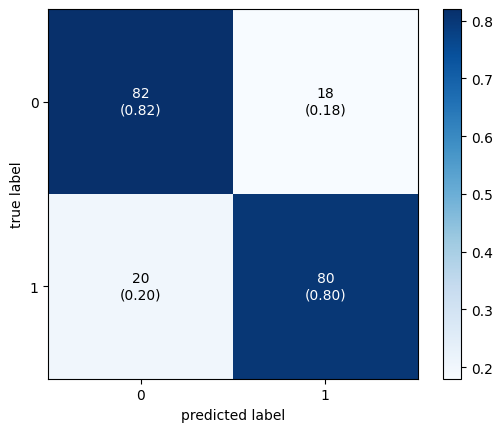

In [77]:
lstm_cm = confusion_matrix(y_test, lstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

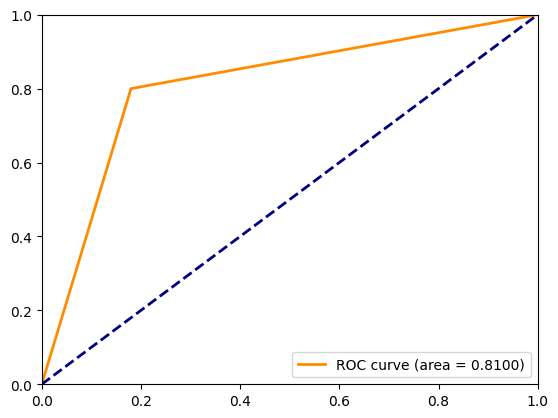

In [78]:
fpr, tpr, _ = roc_curve(y_test, lstm_pred_test)
lstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# GloVe + GRU

In [79]:
gru = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    layers.GRU(100),
    layers.Dense(1, activation='sigmoid')
])

gru.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 11, 100)           378600    
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 439301 (1.68 MB)
Trainable params: 60701 (237.11 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [80]:
model3_train_start = time.time()
gru_results = gru.fit(X_train_tokenizer, 
                      y_train,
                      epochs=25, 
                      batch_size=64, 
                      validation_split=0.1,
                      callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model3_train_time = time.time() - model3_train_start
print(f"GRU Train Time = {model3_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 1s 29ms/step - loss: 0.6432 - accuracy: 0.6556 - val_loss: 0.5939 - val_accuracy: 0.7000
Epoch 2/25
12/12 [==============================] - 0s 11ms/step - loss: 0.5225 - accuracy: 0.7750 - val_loss: 0.5019 - val_accuracy: 0.7875
Epoch 3/25
12/12 [==============================] - 0s 10ms/step - loss: 0.4215 - accuracy: 0.8194 - val_loss: 0.4629 - val_accuracy: 0.7500
Epoch 4/25
12/12 [==============================] - 0s 11ms/step - loss: 0.3660 - accuracy: 0.8417 - val_loss: 0.4667 - val_accuracy: 0.7750
Epoch 5/25
12/12 [==============================] - 0s 8ms/step - loss: 0.3186 - accuracy: 0.8681 - val_loss: 0.4700 - val_accuracy: 0.8000
Epoch 6/25
12/12 [==============================] - 0s 8ms/step - loss: 0.3053 - accuracy: 0.8764 - val_loss: 0.4706 - val_accuracy: 0.7875
Epoch 7/25
12/12 [==============================] - 0s 7ms/step - loss: 0.2643 - accuracy: 0.9014 - val_loss: 0.4690 - val_accuracy: 0.7625
Epoch 8/25
12/12

In [81]:
model3_test_start = time.time()
gru_pred_test = gru.predict(X_test_tokenizer)
model3_test_time = time.time() - model3_test_start
print(f"GRU Test Time = {model3_test_time:.4f}")

7/7 [==============================] - 0s 2ms/step
GRU Test Time = 0.1974


In [82]:
gru_pred_train = gru.predict(X_train_tokenizer)
gru_pred_train = [1 if i > 0.5 else 0 for i in gru_pred_train]
gru_pred_test = [1 if i > 0.5 else 0 for i in gru_pred_test]
gru_train_score = accuracy_score(gru_pred_train, y_train)
gru_test_score = accuracy_score(gru_pred_test, y_test)
print(f"GRU Train Score = {gru_train_score * 100:.4f}%")
print(f"GRU Test Score = {gru_test_score * 100:.4f}%")

25/25 [==============================] - 0s 2ms/step
GRU Train Score = 93.2500%
GRU Test Score = 80.5000%


In [83]:
gru_precision_score = precision_score(y_test, gru_pred_test)
gru_f1_score = f1_score(y_test, gru_pred_test)
gru_recall_score = recall_score(y_test, gru_pred_test)
gru_accuracy_score = accuracy_score(y_test, gru_pred_test)

print(f"GRU Precision Score = {gru_precision_score * 100:.4f}%")
print(f"GRU F1 Score = {gru_f1_score * 100:.4f}%")
print(f"GRU Recall Score = {gru_recall_score * 100:.4f}%")
print(f"GRU Accuracy Score = {gru_accuracy_score * 100:.4f}%")

GRU Precision Score = 79.0476%
GRU F1 Score = 80.9756%
GRU Recall Score = 83.0000%
GRU Accuracy Score = 80.5000%


In [84]:
print(classification_report(y_test, gru_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       100
           1       0.79      0.83      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200



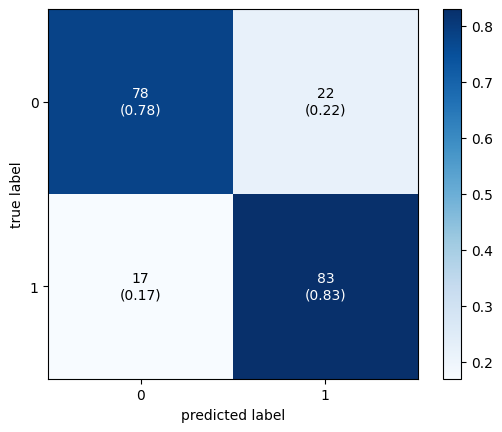

In [85]:
gru_cm = confusion_matrix(y_test, gru_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

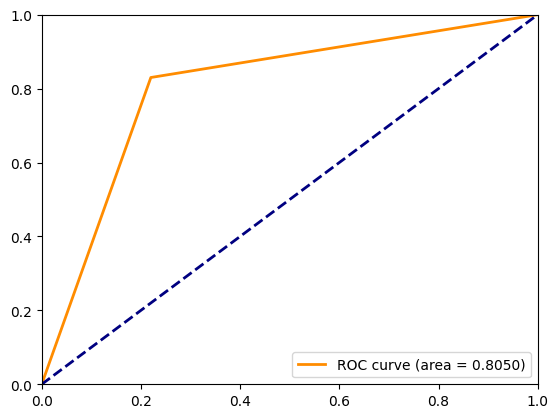

In [86]:
fpr, tpr, _ = roc_curve(y_test, gru_pred_test)
gru_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {gru_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# GloVe + Bi-LSTM

In [87]:
bilstm = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation='sigmoid')
])

bilstm.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 11, 100)           378600    
                                                                 
 bidirectional (Bidirection  (None, 11, 200)           160800    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 200)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 539601 (2.06 MB)
Trainable params: 161001 (628.91 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [88]:
model4_train_start = time.time()
bilstm_results = bilstm.fit(X_train_tokenizer, 
                            y_train, 
                            epochs=25, 
                            batch_size=64, 
                            validation_split=0.1,
                            callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model4_train_time = time.time() - model4_train_start
print(f"Bi-LSTM Train Time = {model4_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 2s 53ms/step - loss: 0.6619 - accuracy: 0.6528 - val_loss: 0.6293 - val_accuracy: 0.7500
Epoch 2/25
12/12 [==============================] - 0s 16ms/step - loss: 0.5566 - accuracy: 0.7778 - val_loss: 0.5494 - val_accuracy: 0.7500
Epoch 3/25
12/12 [==============================] - 0s 15ms/step - loss: 0.4434 - accuracy: 0.8208 - val_loss: 0.4985 - val_accuracy: 0.7625
Epoch 4/25
12/12 [==============================] - 0s 14ms/step - loss: 0.3671 - accuracy: 0.8458 - val_loss: 0.4484 - val_accuracy: 0.7875
Epoch 5/25
12/12 [==============================] - 0s 13ms/step - loss: 0.3004 - accuracy: 0.8722 - val_loss: 0.4057 - val_accuracy: 0.8250
Epoch 6/25
12/12 [==============================] - 0s 13ms/step - loss: 0.2458 - accuracy: 0.9042 - val_loss: 0.3935 - val_accuracy: 0.8625
Epoch 7/25
12/12 [==============================] - 0s 12ms/step - loss: 0.2179 - accuracy: 0.9181 - val_loss: 0.4121 - val_accuracy: 0.8625
Epoch 8/25
12

In [89]:
model4_test_start = time.time()
bilstm_pred_test = bilstm.predict(X_test_tokenizer)
model4_test_time = time.time() - model4_test_start
print(f"Bi-LSTM Test Time = {model4_test_time:.4f}")

7/7 [==============================] - 0s 4ms/step
Bi-LSTM Test Time = 0.3619


In [90]:
bilstm_pred_train = bilstm.predict(X_train_tokenizer)
bilstm_pred_train = [1 if i > 0.5 else 0 for i in bilstm_pred_train]
bilstm_pred_test = [1 if i > 0.5 else 0 for i in bilstm_pred_test]
bilstm_train_score = accuracy_score(bilstm_pred_train, y_train)
bilstm_test_score = accuracy_score(bilstm_pred_test, y_test)
print(f"BILSTM Train Score = {bilstm_train_score * 100:.4f}%")
print(f"BILSTM Test Score = {bilstm_test_score * 100:.4f}%")

25/25 [==============================] - 0s 4ms/step
BILSTM Train Score = 98.5000%
BILSTM Test Score = 84.0000%


In [91]:
bilstm_precision_score = precision_score(y_test, bilstm_pred_test)
bilstm_f1_score = f1_score(y_test, bilstm_pred_test)
bilstm_recall_score = recall_score(y_test, bilstm_pred_test)
bilstm_accuracy_score = accuracy_score(y_test, bilstm_pred_test)

print(f"BILSTM Precision Score = {bilstm_precision_score * 100:.4f}%")
print(f"BILSTM F1 Score = {bilstm_f1_score * 100:.4f}%")
print(f"BILSTM Recall Score = {bilstm_recall_score * 100:.4f}%")
print(f"BILSTM Accuracy Score = {bilstm_accuracy_score * 100:.4f}%")

BILSTM Precision Score = 84.6939%
BILSTM F1 Score = 83.8384%
BILSTM Recall Score = 83.0000%
BILSTM Accuracy Score = 84.0000%


In [92]:
print(classification_report(y_test, bilstm_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       100
           1       0.85      0.83      0.84       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



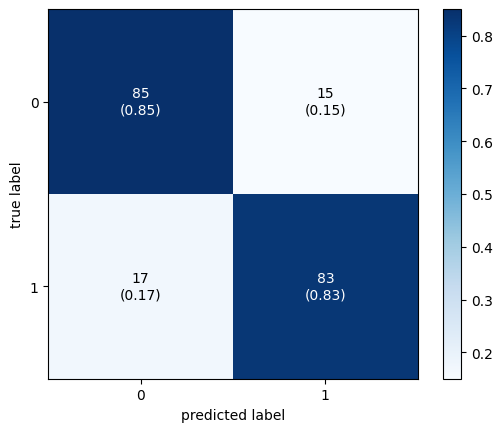

In [93]:
bilstm_cm = confusion_matrix(y_test, bilstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=bilstm_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

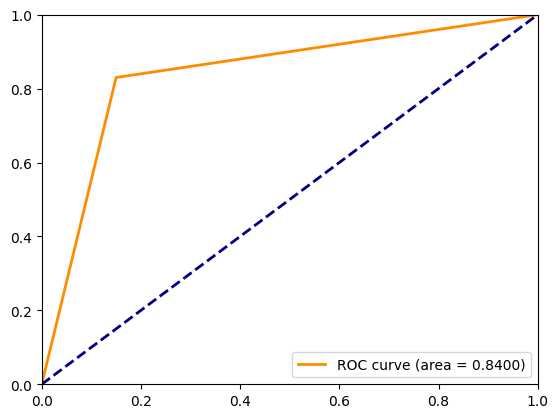

In [94]:
fpr, tpr, _ = roc_curve(y_test, bilstm_pred_test)
bilstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {bilstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# FastText

In [95]:
model5_train_start = time.time()
fasttext_model = fasttext.train_supervised("fasttext_train.txt", epoch=50, lr=0.05, label_prefix="__label__", dim=300)
model5_train_time = time.time() - model5_train_start
print(f"FastText Train Time = {model5_train_time:.4f}")

FastText Train Time = 0.1570


Read 0M words
Number of words:  3165
Number of labels: 2
Progress: 100.0% words/sec/thread:  309214 lr:  0.000000 avg.loss:  0.175515 ETA:   0h 0m 0s


In [96]:
def predict_fasttext(row):
    pred = fasttext_model.predict(row)[0][0].replace("__label__", "")
    return dict(zip(le.classes_, le.transform(le.classes_)))[pred]

In [97]:
model5_test_start = time.time()
fasttext_pred_test = [predict_fasttext(test) for test in X_test]
model5_test_time = time.time() - model5_test_start
print(f"FastText Test Time = {model5_test_time:.4f}")

FastText Test Time = 0.0117


In [98]:
fasttext_pred_train = [predict_fasttext(train) for train in X_train]
fasttext_train_score = accuracy_score(fasttext_pred_train, y_train)
fasttext_test_score = accuracy_score(fasttext_pred_test, y_test)
print(f"FastText Train Score = {fasttext_train_score * 100:.4f}%")
print(f"FastText Test Score = {fasttext_test_score * 100:.4f}%")

FastText Train Score = 100.0000%
FastText Test Score = 94.0000%


In [99]:
fasttext_precision_score = precision_score(y_test, fasttext_pred_test)
fasttext_f1_score = f1_score(y_test, fasttext_pred_test)
fasttext_recall_score = recall_score(y_test, fasttext_pred_test)
fasttext_accuracy_score = accuracy_score(y_test, fasttext_pred_test)

print(f"FastText Precision Score = {fasttext_precision_score * 100:.4f}%")
print(f"FastText F1 Score = {fasttext_f1_score * 100:.4f}%")
print(f"FastText Recall Score = {fasttext_recall_score * 100:.4f}%")
print(f"FastText Accuracy Score = {fasttext_accuracy_score * 100:.4f}%")

FastText Precision Score = 95.8333%
FastText F1 Score = 93.8776%
FastText Recall Score = 92.0000%
FastText Accuracy Score = 94.0000%


In [100]:
print(classification_report(y_test, fasttext_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       100
           1       0.96      0.92      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



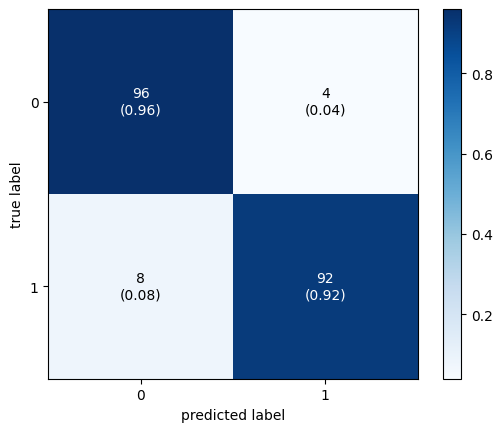

In [101]:
fasttext_cm = confusion_matrix(y_test, fasttext_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=fasttext_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

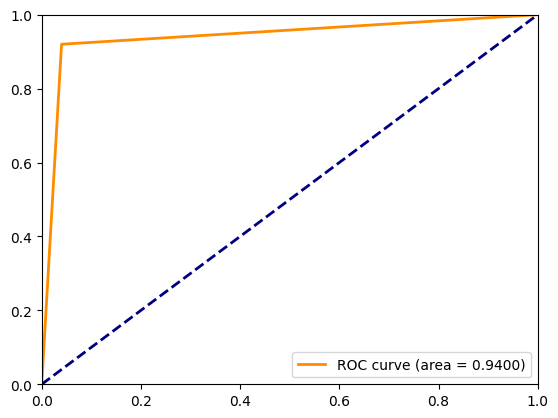

In [156]:
fpr, tpr, _ = roc_curve(y_test, fasttext_pred_test)
fasttext_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {fasttext_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# BERT

In [102]:
bert_model = ClassificationModel(
    "bert",
    "dbmdz/bert-base-turkish-uncased",
    num_labels=2,
    use_cuda=True,
    args={
        "reprocess_input_data": True,
        "overwrite_output_dir": True,
        "num_train_epochs": 3,
        "train_batch_size": 64,
        "fp16": False,
        "output_dir": "bert_model",
        "use_multiprocessing": False,
        "use_multiprocessing_for_evaluation": False,
        "use_multiprocessed_decoding": False,
    }
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [103]:
model6_train_start = time.time()
bert_model.train_model(train_df[["text", "labels"]], output_dir="bert_model")
model6_train_time = time.time() - model6_train_start
print(f"BERT Train Time = {model6_train_time:.4f}")

2024-04-21 17:28:23,729 - simpletransformers.classification.classification_utils - INFO
Msg:  Converting to features started. Cache is not used.

2024-04-21 17:28:23,807 - simpletransformers.classification.classification_utils - INFO
Msg:  Saving features into cached file cache_dir/cached_train_bert_128_2_2



Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/13 [00:00<?, ?it/s]

2024-04-21 17:35:24,680 - simpletransformers.classification.classification_model - INFO
Msg:  Training of bert model complete. Saved to bert_model.

BERT Train Time = 421.2453


In [104]:
model6_test_start = time.time()
bert_result, bert_model_outputs, bert_wrong_predictions = bert_model.eval_model(test_df[["text", "labels"]])
model6_test_time = time.time() - model6_test_start
print(f"BERT Test Time = {model6_test_time:.4f}")

2024-04-21 17:35:24,749 - simpletransformers.classification.classification_utils - INFO
Msg:  Converting to features started. Cache is not used.

2024-04-21 17:35:24,765 - simpletransformers.classification.classification_utils - INFO
Msg:  Saving features into cached file cache_dir/cached_dev_bert_128_2_2



Running Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

2024-04-21 17:35:34,595 - simpletransformers.classification.classification_model - INFO
Msg: {'mcc': 0.8921885461995414, 'tp': 91, 'tn': 98, 'fp': 2, 'fn': 9, 'auroc': 0.9899, 'auprc': 0.9912874224635265, 'eval_loss': 0.15617123246192932}

BERT Test Time = 9.8529


In [105]:
bert_pred_test = bert_model_outputs.argmax(axis=1)

In [106]:
bert_result, bert_model_outputs, bert_wrong_predictions = bert_model.eval_model(train_df[["text", "labels"]])
bert_pred_train = bert_model_outputs.argmax(axis=1)
bert_train_score = accuracy_score(bert_pred_train, y_train)
bert_test_score = accuracy_score(bert_pred_test, y_test)
print(f"BERT Train Score = {bert_train_score * 100:.4f}%")
print(f"BERT Test Score = {bert_test_score * 100:.4f}%")

2024-04-21 17:35:34,678 - simpletransformers.classification.classification_utils - INFO
Msg:  Converting to features started. Cache is not used.

2024-04-21 17:35:34,735 - simpletransformers.classification.classification_utils - INFO
Msg:  Saving features into cached file cache_dir/cached_dev_bert_128_2_2



Running Evaluation:   0%|          | 0/8 [00:00<?, ?it/s]

2024-04-21 17:36:06,576 - simpletransformers.classification.classification_model - INFO
Msg: {'mcc': 0.9651085808233575, 'tp': 390, 'tn': 396, 'fp': 4, 'fn': 10, 'auroc': 0.99636875, 'auprc': 0.996213238981902, 'eval_loss': 0.07330955471843481}

BERT Train Score = 98.2500%
BERT Test Score = 94.5000%


In [107]:
bert_precision_score = precision_score(y_test, bert_pred_test)
bert_f1_score = f1_score(y_test, bert_pred_test)
bert_recall_score = recall_score(y_test, bert_pred_test)
bert_accuracy_score = accuracy_score(y_test, bert_pred_test)

print(f"BERT Precision Score = {bert_precision_score * 100:.4f}%")
print(f"BERT F1 Score = {bert_f1_score * 100:.4f}%")
print(f"BERT Recall Score = {bert_recall_score * 100:.4f}%")
print(f"BERt Accuracy Score = {bert_accuracy_score * 100:.4f}%")

BERT Precision Score = 97.8495%
BERT F1 Score = 94.3005%
BERT Recall Score = 91.0000%
BERt Accuracy Score = 94.5000%


In [108]:
print(classification_report(y_test, bert_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       100
           1       0.98      0.91      0.94       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



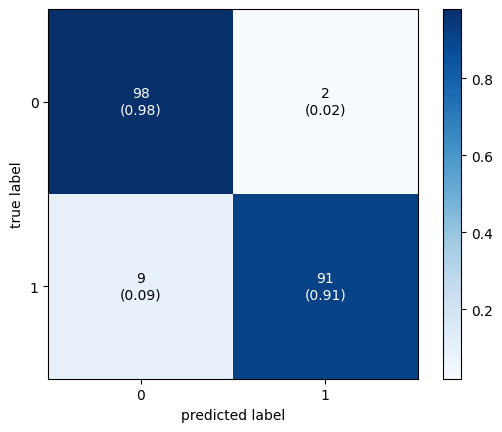

In [109]:
bert_cm = confusion_matrix(y_test, bert_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=bert_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

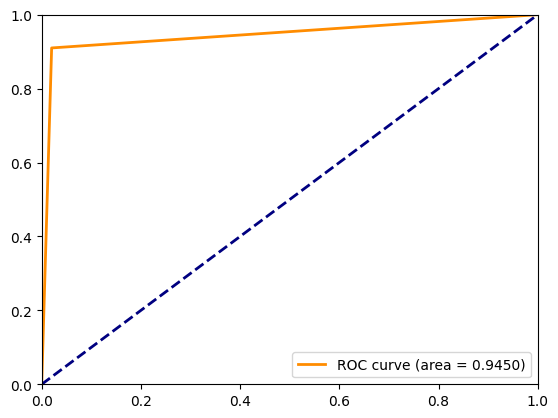

In [158]:
fpr, tpr, _ = roc_curve(y_test, bert_pred_test)
bert_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {bert_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Word2Vec + SimpleRNN

In [110]:
simplernn2 = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[wv_embedding_matrix], input_length=maxlen, trainable=False),
    layers.SimpleRNN(100),
    layers.Dense(1, activation='sigmoid')
])

simplernn2.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])    

simplernn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 11, 100)           378600    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 398801 (1.52 MB)
Trainable params: 20201 (78.91 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [111]:
model7_train_start = time.time()
simplernn_history = simplernn2.fit(X_train_tokenizer, 
                                  y_train, 
                                  epochs=25, 
                                  batch_size=64, 
                                  validation_split=0.1, 
                                  callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model7_train_time = time.time() - model7_train_start
print(f"SimpleRNN Train Time = {model7_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 1s 35ms/step - loss: 0.6930 - accuracy: 0.5083 - val_loss: 0.6914 - val_accuracy: 0.5875
Epoch 2/25
12/12 [==============================] - 0s 20ms/step - loss: 0.6899 - accuracy: 0.5889 - val_loss: 0.6905 - val_accuracy: 0.5500
Epoch 3/25
12/12 [==============================] - 0s 18ms/step - loss: 0.6871 - accuracy: 0.5528 - val_loss: 0.6898 - val_accuracy: 0.5500
Epoch 4/25
12/12 [==============================] - 0s 16ms/step - loss: 0.6888 - accuracy: 0.5514 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 5/25
12/12 [==============================] - 0s 18ms/step - loss: 0.6802 - accuracy: 0.6278 - val_loss: 0.6894 - val_accuracy: 0.4875
Epoch 6/25
12/12 [==============================] - 0s 16ms/step - loss: 0.6744 - accuracy: 0.5944 - val_loss: 0.6898 - val_accuracy: 0.5875
SimpleRNN Train Time = 2.5379


In [115]:
model7_test_start = time.time()
simplernn2_pred_test = simplernn2.predict(X_test_tokenizer)
model7_test_time = time.time() - model7_test_start
print(f"SimpleRNN Test Time = {model7_test_time:.4f}")

7/7 [==============================] - 0s 3ms/step
SimpleRNN Test Time = 0.0626


In [116]:
simplernn2_pred_train = simplernn2.predict(X_train_tokenizer)
simplernn2_pred_train = [1 if i > 0.5 else 0 for i in simplernn2_pred_train]
simplernn2_pred_test = [1 if i > 0.5 else 0 for i in simplernn2_pred_test]
simplernn2_train_score = accuracy_score(simplernn2_pred_train, y_train)
simplernn2_test_score = accuracy_score(simplernn2_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn2_train_score * 100:.4f}%")
print(f"SimpleRNN Test Score = {simplernn2_test_score * 100:.4f}%")

25/25 [==============================] - 0s 3ms/step
SimpleRNN Train Score = 70.1250%
SimpleRNN Test Score = 64.5000%


In [117]:
simplernn2_precision_score = precision_score(y_test, simplernn2_pred_test)
simplernn2_f1_score = f1_score(y_test, simplernn2_pred_test)
simplernn2_recall_score = recall_score(y_test, simplernn2_pred_test)
simplernn2_accuracy_score = accuracy_score(y_test, simplernn2_pred_test)

print(f"SimpleRNN Precision Score = {simplernn2_precision_score * 100:.4f}%")
print(f"SimpleRNN F1 Score = {simplernn2_f1_score * 100:.4f}%")
print(f"SimpleRNN Recall Score = {simplernn2_recall_score * 100:.4f}%")
print(f"SimpleRNN Accuracy Score = {simplernn2_accuracy_score * 100:.4f}%")

SimpleRNN Precision Score = 60.2837%
SimpleRNN F1 Score = 70.5394%
SimpleRNN Recall Score = 85.0000%
SimpleRNN Accuracy Score = 64.5000%


In [118]:
print(classification_report(y_test, simplernn2_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.44      0.55       100
           1       0.60      0.85      0.71       100

    accuracy                           0.65       200
   macro avg       0.67      0.65      0.63       200
weighted avg       0.67      0.65      0.63       200



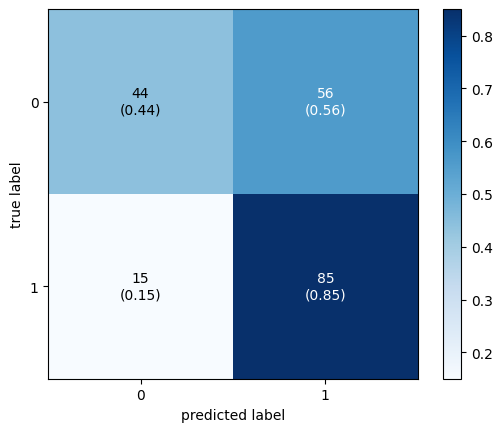

In [119]:
simplernn2_cm = confusion_matrix(y_test, simplernn2_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn2_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

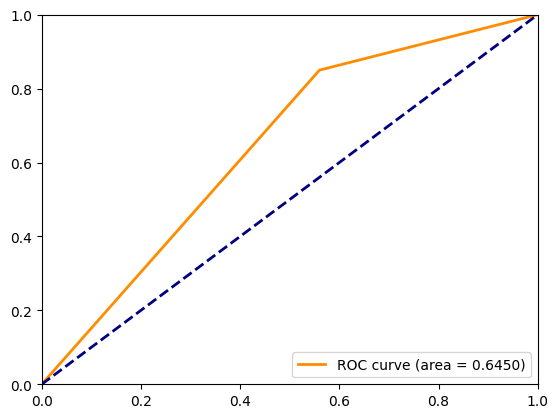

In [120]:
fpr, tpr, _ = roc_curve(y_test, simplernn2_pred_test)
simplernn2_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {simplernn2_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Word2Vec + LSTM

In [121]:
lstm2 = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[wv_embedding_matrix], input_length=maxlen, trainable=False),
    layers.LSTM(100),
    layers.Dense(1, activation='sigmoid')
])

lstm2.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

lstm2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 11, 100)           378600    
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 459101 (1.75 MB)
Trainable params: 80501 (314.46 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [122]:
model8_train_start = time.time()
lstm2_results = lstm2.fit(X_train_tokenizer, 
                        y_train, 
                        epochs=25, 
                        batch_size=64, 
                        validation_split=0.1,
                        callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model8_train_time = time.time() - model8_train_start
print(f"LSTM Train Time = {model8_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 2s 47ms/step - loss: 0.6931 - accuracy: 0.4931 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/25
12/12 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.5597 - val_loss: 0.6922 - val_accuracy: 0.7375
Epoch 3/25
12/12 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.6917 - val_loss: 0.6914 - val_accuracy: 0.6875
Epoch 4/25
12/12 [==============================] - 0s 9ms/step - loss: 0.6909 - accuracy: 0.5528 - val_loss: 0.6900 - val_accuracy: 0.5000
Epoch 5/25
12/12 [==============================] - 0s 10ms/step - loss: 0.6891 - accuracy: 0.5000 - val_loss: 0.6880 - val_accuracy: 0.7375
Epoch 6/25
12/12 [==============================] - 0s 10ms/step - loss: 0.6896 - accuracy: 0.5431 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 7/25
12/12 [==============================] - 0s 9ms/step - loss: 0.6878 - accuracy: 0.5292 - val_loss: 0.6890 - val_accuracy: 0.5000
LSTM Train Time =

In [123]:
model8_test_start = time.time()
lstm2_pred_test = lstm2.predict(X_test_tokenizer)
model8_test_time = time.time() - model8_test_start
print(f"LSTM Test Time = {model8_test_time:.4f}")

7/7 [==============================] - 0s 35ms/step
LSTM Test Time = 0.4333


In [124]:
lstm2_pred_train = lstm2.predict(X_train_tokenizer)
lstm2_pred_train = [1 if i > 0.5 else 0 for i in lstm2_pred_train]
lstm2_pred_test = [1 if i > 0.5 else 0 for i in lstm2_pred_test]
lstm2_train_score = accuracy_score(lstm2_pred_train, y_train)
lstm2_test_score = accuracy_score(lstm2_pred_test, y_test)
print(f"LSTM Train Score = {lstm2_train_score * 100:.4f}%")
print(f"LSTM Test Score = {lstm2_test_score * 100:.4f}%")

25/25 [==============================] - 0s 10ms/step
LSTM Train Score = 50.0000%
LSTM Test Score = 50.0000%


In [125]:
lstm2_precision_score = precision_score(y_test, lstm2_pred_test)
lstm2_f1_score = f1_score(y_test, lstm2_pred_test)
lstm2_recall_score = recall_score(y_test, lstm2_pred_test)
lstm2_accuracy_score = accuracy_score(y_test, lstm2_pred_test)

print(f"LSTM Precision Score = {lstm2_precision_score * 100:.4f}%")
print(f"LSTM F1 Score = {lstm2_f1_score * 100:.4f}%")
print(f"LSTM Recall Score = {lstm2_recall_score * 100:.4f}%")
print(f"LSTM Accuracy Score = {lstm2_accuracy_score * 100:.4f}%")

LSTM Precision Score = 0.0000%
LSTM F1 Score = 0.0000%
LSTM Recall Score = 0.0000%
LSTM Accuracy Score = 50.0000%


In [126]:
print(classification_report(y_test, lstm2_pred_test))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       100
           1       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



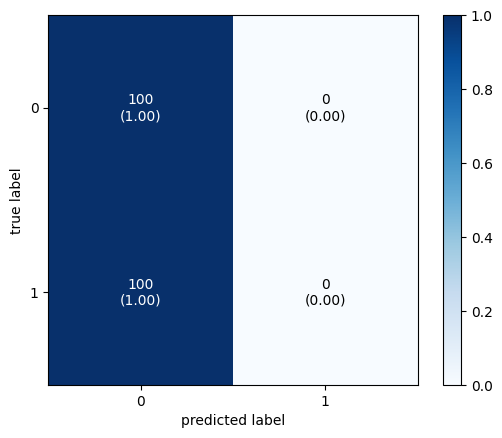

In [127]:
lstm2_cm = confusion_matrix(y_test, lstm2_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm2_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

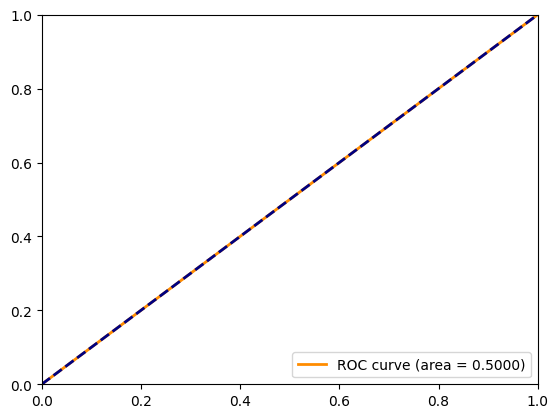

In [128]:
fpr, tpr, _ = roc_curve(y_test, lstm2_pred_test)
lstm2_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm2_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Word2Vec + GRU

In [129]:
gru2 = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[wv_embedding_matrix], input_length=maxlen, trainable=False),
    layers.GRU(100),
    layers.Dense(1, activation='sigmoid')
])

gru2.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

gru2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 11, 100)           378600    
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 439301 (1.68 MB)
Trainable params: 60701 (237.11 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [130]:
model9_train_start = time.time()
gru2_results = gru2.fit(X_train_tokenizer, 
                      y_train,
                      epochs=25, 
                      batch_size=64, 
                      validation_split=0.1,
                      callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model9_train_time = time.time() - model9_train_start
print(f"GRU Train Time = {model9_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 1s 36ms/step - loss: 0.6934 - accuracy: 0.4958 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/25
12/12 [==============================] - 0s 16ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 3/25
12/12 [==============================] - 0s 8ms/step - loss: 0.6915 - accuracy: 0.5500 - val_loss: 0.6914 - val_accuracy: 0.6375
Epoch 4/25
12/12 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.6556 - val_loss: 0.6904 - val_accuracy: 0.7625
Epoch 5/25
12/12 [==============================] - 0s 9ms/step - loss: 0.6890 - accuracy: 0.5694 - val_loss: 0.6889 - val_accuracy: 0.5375
Epoch 6/25
12/12 [==============================] - 0s 9ms/step - loss: 0.6865 - accuracy: 0.5208 - val_loss: 0.6859 - val_accuracy: 0.5250
Epoch 7/25
12/12 [==============================] - 0s 8ms/step - loss: 0.6830 - accuracy: 0.5556 - val_loss: 0.6835 - val_accuracy: 0.5000
Epoch 8/25
12/12 [

In [131]:
model9_test_start = time.time()
gru2_pred_test = gru2.predict(X_test_tokenizer)
model9_test_time = time.time() - model9_test_start
print(f"GRU Test Time = {model9_test_time:.4f}")

7/7 [==============================] - 0s 8ms/step
GRU Test Time = 0.2577


In [132]:
gru2_pred_train = gru2.predict(X_train_tokenizer)
gru2_pred_train = [1 if i > 0.5 else 0 for i in gru2_pred_train]
gru2_pred_test = [1 if i > 0.5 else 0 for i in gru2_pred_test]
gru2_train_score = accuracy_score(gru2_pred_train, y_train)
gru2_test_score = accuracy_score(gru2_pred_test, y_test)
print(f"GRU Train Score = {gru2_train_score * 100:.4f}%")
print(f"GRU Test Score = {gru2_test_score * 100:.4f}%")

25/25 [==============================] - 0s 8ms/step
GRU Train Score = 73.8750%
GRU Test Score = 66.5000%


In [133]:
gru2_precision_score = precision_score(y_test, gru2_pred_test)
gru2_f1_score = f1_score(y_test, gru2_pred_test)
gru2_recall_score = recall_score(y_test, gru2_pred_test)
gru2_accuracy_score = accuracy_score(y_test, gru2_pred_test)

print(f"GRU Precision Score = {gru2_precision_score * 100:.4f}%")
print(f"GRU F1 Score = {gru2_f1_score * 100:.4f}%")
print(f"GRU Recall Score = {gru2_recall_score * 100:.4f}%")
print(f"GRU Accuracy Score = {gru2_accuracy_score * 100:.4f}%")

GRU Precision Score = 90.2439%
GRU F1 Score = 52.4823%
GRU Recall Score = 37.0000%
GRU Accuracy Score = 66.5000%


In [134]:
print(classification_report(y_test, gru2_pred_test))

              precision    recall  f1-score   support

           0       0.60      0.96      0.74       100
           1       0.90      0.37      0.52       100

    accuracy                           0.67       200
   macro avg       0.75      0.67      0.63       200
weighted avg       0.75      0.67      0.63       200



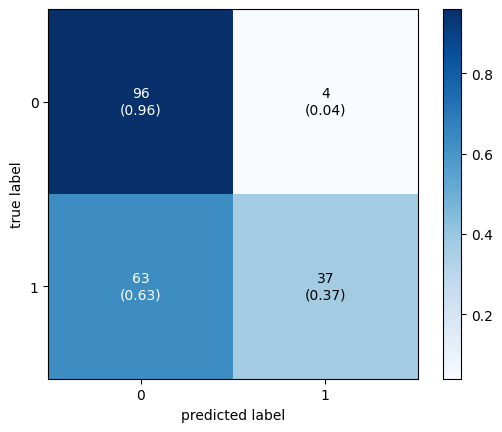

In [135]:
gru2_cm = confusion_matrix(y_test, gru2_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru2_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

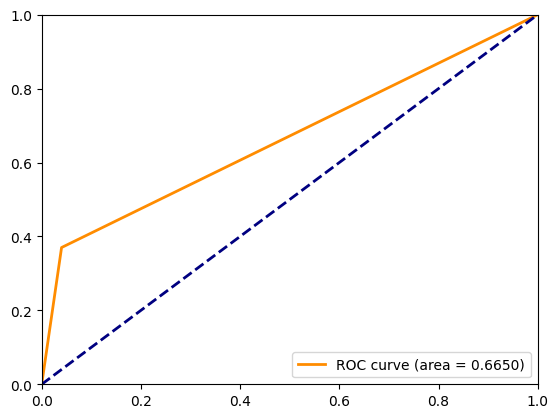

In [136]:
fpr, tpr, _ = roc_curve(y_test, gru2_pred_test)
gru2_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {gru2_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Word2Vec + Bi-LSTM

In [137]:
bilstm2 = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[wv_embedding_matrix], input_length=maxlen, trainable=False),
    layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(1, activation='sigmoid')
])

bilstm2.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

bilstm2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 11, 100)           378600    
                                                                 
 bidirectional_1 (Bidirecti  (None, 11, 200)           160800    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 539601 (2.06 MB)
Trainable params: 161001 (628.91 KB)
Non-trainable params: 378600 (1.44 MB)
_________________________________________________________________


In [138]:
model10_train_start = time.time()
bilstm2_results = bilstm2.fit(X_train_tokenizer, 
                            y_train, 
                            epochs=25, 
                            batch_size=64, 
                            validation_split=0.1,
                            callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])
model10_train_time = time.time() - model10_train_start
print(f"Bi-LSTM Train Time = {model10_train_time:.4f}")

Epoch 1/25
12/12 [==============================] - 2s 64ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/25
12/12 [==============================] - 0s 13ms/step - loss: 0.6926 - accuracy: 0.5431 - val_loss: 0.6924 - val_accuracy: 0.7250
Epoch 3/25
12/12 [==============================] - 0s 13ms/step - loss: 0.6920 - accuracy: 0.6792 - val_loss: 0.6919 - val_accuracy: 0.6625
Epoch 4/25
12/12 [==============================] - 0s 14ms/step - loss: 0.6912 - accuracy: 0.6097 - val_loss: 0.6911 - val_accuracy: 0.5500
Epoch 5/25
12/12 [==============================] - 0s 12ms/step - loss: 0.6886 - accuracy: 0.6889 - val_loss: 0.6829 - val_accuracy: 0.6750
Epoch 6/25
12/12 [==============================] - 0s 13ms/step - loss: 0.6528 - accuracy: 0.6694 - val_loss: 0.6201 - val_accuracy: 0.6125
Epoch 7/25
12/12 [==============================] - 0s 12ms/step - loss: 0.5630 - accuracy: 0.6972 - val_loss: 0.5039 - val_accuracy: 0.7750
Epoch 8/25
12

In [139]:
model10_test_start = time.time()
bilstm2_pred_test = bilstm2.predict(X_test_tokenizer)
model10_test_time = time.time() - model10_test_start
print(f"Bi-LSTM Test Time = {model10_test_time:.4f}")

7/7 [==============================] - 1s 32ms/step
Bi-LSTM Test Time = 0.5590


In [140]:
bilstm2_pred_train = bilstm2.predict(X_train_tokenizer)
bilstm2_pred_train = [1 if i > 0.5 else 0 for i in bilstm2_pred_train]
bilstm2_pred_test = [1 if i > 0.5 else 0 for i in bilstm2_pred_test]
bilstm2_train_score = accuracy_score(bilstm2_pred_train, y_train)
bilstm2_test_score = accuracy_score(bilstm2_pred_test, y_test)
print(f"BILSTM Train Score = {bilstm2_train_score * 100:.4f}%")
print(f"BILSTM Test Score = {bilstm2_test_score * 100:.4f}%")

25/25 [==============================] - 0s 18ms/step
BILSTM Train Score = 77.8750%
BILSTM Test Score = 76.5000%


In [141]:
bilstm2_precision_score = precision_score(y_test, bilstm2_pred_test)
bilstm2_f1_score = f1_score(y_test, bilstm2_pred_test)
bilstm2_recall_score = recall_score(y_test, bilstm2_pred_test)
bilstm2_accuracy_score = accuracy_score(y_test, bilstm2_pred_test)

print(f"BILSTM Precision Score = {bilstm2_precision_score * 100:.4f}%")
print(f"BILSTM F1 Score = {bilstm2_f1_score * 100:.4f}%")
print(f"BILSTM Recall Score = {bilstm2_recall_score * 100:.4f}%")
print(f"BILSTM Accuracy Score = {bilstm2_accuracy_score * 100:.4f}%")

BILSTM Precision Score = 92.0635%
BILSTM F1 Score = 71.1656%
BILSTM Recall Score = 58.0000%
BILSTM Accuracy Score = 76.5000%


In [142]:
print(classification_report(y_test, bilstm2_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80       100
           1       0.92      0.58      0.71       100

    accuracy                           0.77       200
   macro avg       0.81      0.76      0.76       200
weighted avg       0.81      0.77      0.76       200



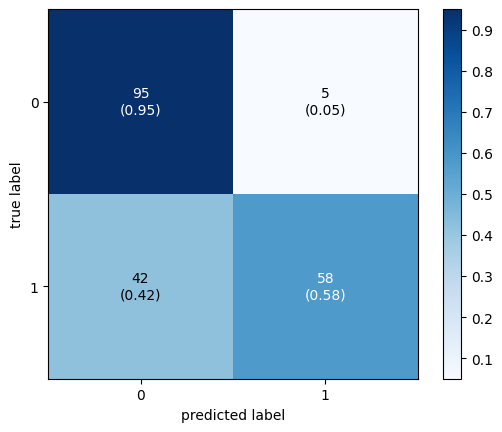

In [143]:
bilstm2_cm = confusion_matrix(y_test, bilstm2_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=bilstm2_cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

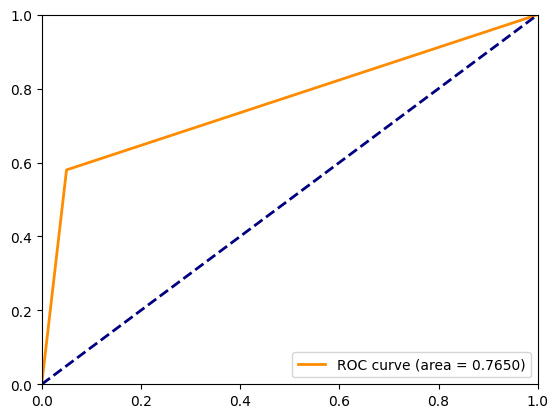

In [144]:
fpr, tpr, _ = roc_curve(y_test, bilstm2_pred_test)
bilstm2_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {bilstm2_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Results

In [145]:
scores_df = pd.DataFrame(columns=["Model Name", "Train Time", "Test Time", "Train Accuracy", "Test Accuracy",
                                  "Accuracy", "F1", "Precision", "Recall", "ROC-AUC"])

In [146]:
scores_df.loc[0] = ["MultinomialNB + TFIDF",
                    mnb_tfidf_train_time,
                    mnb_tfidf_test_time,
                    mnb_tfidf_train_score,
                    mnb_tfidf_test_score,
                    mnb_tfidf_accuracy_score,
                    mnb_tfidf_f1_score,
                    mnb_tfidf_precision_score,
                    mnb_tfidf_recall_score,
                    mnb_tfidf_roc_auc_score]

In [147]:
scores_df.loc[1] = ["MultinomialNB + CV",
                    mnb_cv_train_time,
                    mnb_cv_test_time,
                    mnb_cv_train_score,
                    mnb_cv_test_score,
                    mnb_cv_accuracy_score,
                    mnb_cv_f1_score,
                    mnb_cv_precision_score,
                    mnb_cv_recall_score,
                    mnb_cv_roc_auc_score]

In [148]:
scores_df.loc[2] = ["Random Forest + TFIDF",
                    rf_tfidf_train_time,
                    rf_tfidf_test_time,
                    rf_tfidf_train_score,
                    rf_tfidf_test_score,
                    rf_tfidf_accuracy_score,
                    rf_tfidf_f1_score,
                    rf_tfidf_precision_score,
                    rf_tfidf_recall_score,
                    rf_tfidf_roc_auc_score]

In [149]:
scores_df.loc[3] = ["Random Forest + CV",
                    rf_cv_train_time,
                    rf_cv_test_time,
                    rf_cv_train_score,
                    rf_cv_test_score,
                    rf_cv_accuracy_score,
                    rf_cv_f1_score,
                    rf_cv_precision_score,
                    rf_cv_recall_score,
                    rf_cv_roc_auc_score]

In [150]:
scores_df.loc[4] = ["XGB + TFIDF",
                    xgb_tfidf_train_time,
                    xgb_tfidf_test_time,
                    xgb_tfidf_train_score,
                    xgb_tfidf_test_score,
                    xgb_tfidf_accuracy_score,
                    xgb_tfidf_f1_score,
                    xgb_tfidf_precision_score,
                    xgb_tfidf_recall_score,
                    xgb_tfidf_roc_auc_score]

In [151]:
scores_df.loc[5] = ["XGB + CV",
                    xgb_cv_train_time,
                    xgb_cv_test_time,
                    xgb_cv_train_score,
                    xgb_cv_test_score,
                    xgb_cv_accuracy_score,
                    xgb_cv_f1_score,
                    xgb_cv_precision_score,
                    xgb_cv_recall_score,
                    xgb_cv_roc_auc_score]

In [152]:
scores_df.loc[6] = ["SimpleRNN + GloVe",
                    model1_train_time,
                    model1_test_time,
                    simplernn_train_score,
                    simplernn_test_score,
                    simplernn_accuracy_score,
                    simplernn_f1_score,
                    simplernn_precision_score,
                    simplernn_recall_score,
                    simplernn_roc_auc]

In [153]:
scores_df.loc[7] = ["LSTM + GloVe",
                    model2_train_time,
                    model2_test_time,
                    lstm_train_score,
                    lstm_test_score,
                    lstm_accuracy_score,
                    lstm_f1_score,
                    lstm_precision_score,
                    lstm_recall_score,
                    lstm_roc_auc]

In [154]:
scores_df.loc[8] = ["GRU + GloVe",
                    model3_train_time,
                    model3_test_time,
                    gru_train_score,
                    gru_test_score,
                    gru_accuracy_score,
                    gru_f1_score,
                    gru_precision_score,
                    gru_recall_score,
                    gru_roc_auc]

In [155]:
scores_df.loc[9] = ["Bi-LSTM + GloVe",
                    model4_train_time,
                    model4_test_time,
                    bilstm_train_score,
                    bilstm_test_score,
                    bilstm_accuracy_score,
                    bilstm_f1_score,
                    bilstm_precision_score,
                    bilstm_recall_score,
                    bilstm_roc_auc]

In [157]:
scores_df.loc[10] = ["FastText",
                    model5_train_time,
                    model5_test_time,
                    fasttext_train_score,
                    fasttext_test_score,
                    fasttext_accuracy_score,
                    fasttext_f1_score,
                    fasttext_precision_score,
                    fasttext_recall_score,
                    fasttext_roc_auc]

In [159]:
scores_df.loc[11] = ["BERT",
                    model6_train_time,
                    model6_test_time,
                    bert_train_score,
                    bert_test_score,
                    bert_accuracy_score,
                    bert_f1_score,
                    bert_precision_score,
                    bert_recall_score,
                    bert_roc_auc]

In [172]:
scores_df.loc[12] = ["SimpleRNN + Word2Vec",
                    model7_train_time,
                    model7_test_time,
                    simplernn2_train_score,
                    simplernn2_test_score,
                    simplernn2_accuracy_score,
                    simplernn2_f1_score,
                    simplernn2_precision_score,
                    simplernn2_recall_score,
                    simplernn2_roc_auc]

In [173]:
scores_df.loc[13] = ["LSTM + Word2Vec",
                    model8_train_time,
                    model8_test_time,
                    lstm2_train_score,
                    lstm2_test_score,
                    lstm2_accuracy_score,
                    lstm2_f1_score,
                    lstm2_precision_score,
                    lstm2_recall_score,
                    lstm2_roc_auc]

In [174]:
scores_df.loc[14] = ["GRU + Word2Vec",
                    model9_train_time,
                    model9_test_time,
                    gru2_train_score,
                    gru2_test_score,
                    gru2_accuracy_score,
                    gru2_f1_score,
                    gru2_precision_score,
                    gru2_recall_score,
                    gru2_roc_auc]

In [175]:
scores_df.loc[15] = ["Bi-LSTM + Word2Vec",
                    model10_train_time,
                    model10_test_time,
                    bilstm2_train_score,
                    bilstm2_test_score,
                    bilstm2_accuracy_score,
                    bilstm2_f1_score,
                    bilstm2_precision_score,
                    bilstm2_recall_score,
                    bilstm2_roc_auc]

In [176]:
scores_df

,Model Name,Train Time,Test Time,Train Accuracy,Test Accuracy,Accuracy,F1,Precision,Recall,ROC-AUC
0,MultinomialNB + TFIDF,0.002760,0.000400,1.00000,0.915,0.915,0.914998,0.915042,0.915,0.915
1,MultinomialNB + CV,0.002091,0.000355,0.99875,0.925,0.925,0.924998,0.925043,0.925,0.925
2,Random Forest + TFIDF,0.167106,0.006383,1.00000,0.920,0.920,0.919799,0.924242,0.920,0.920
3,Random Forest + CV,0.153517,0.007477,1.00000,0.935,0.935,0.934998,0.935044,0.935,0.935
4,XGB + TFIDF,0.352417,0.000827,0.91750,0.840,0.840,0.837250,0.864650,0.840,0.840
5,XGB + CV,0.063206,0.000552,0.91375,0.880,0.880,0.878788,0.895833,0.880,0.880
6,SimpleRNN + GloVe,5.028007,0.151963,0.96625,0.800,0.800,0.800000,0.800000,0.800,0.800
7,LSTM + GloVe,2.639858,0.212024,0.92875,0.810,0.810,0.808081,0.816327,0.800,0.810
8,GRU + GloVe,2.260556,0.197388,0.93250,0.805,0.805,0.809756,0.790476,0.830,0.805
9,Bi-LSTM + GloVe,5.344825,0.361940,0.98500,0.840,0.840,0.838384,0.846939,0.830,0.840


In [177]:
scores_df.sort_values(by='Test Accuracy', ascending=False)

,Model Name,Train Time,Test Time,Train Accuracy,Test Accuracy,Accuracy,F1,Precision,Recall,ROC-AUC
11,BERT,421.245308,9.852937,0.98250,0.945,0.945,0.943005,0.978495,0.910,0.945
10,FastText,0.156960,0.011668,1.00000,0.940,0.940,0.938776,0.958333,0.920,0.940
3,Random Forest + CV,0.153517,0.007477,1.00000,0.935,0.935,0.934998,0.935044,0.935,0.935
1,MultinomialNB + CV,0.002091,0.000355,0.99875,0.925,0.925,0.924998,0.925043,0.925,0.925
2,Random Forest + TFIDF,0.167106,0.006383,1.00000,0.920,0.920,0.919799,0.924242,0.920,0.920
0,MultinomialNB + TFIDF,0.002760,0.000400,1.00000,0.915,0.915,0.914998,0.915042,0.915,0.915
5,XGB + CV,0.063206,0.000552,0.91375,0.880,0.880,0.878788,0.895833,0.880,0.880
4,XGB + TFIDF,0.352417,0.000827,0.91750,0.840,0.840,0.837250,0.864650,0.840,0.840
9,Bi-LSTM + GloVe,5.344825,0.361940,0.98500,0.840,0.840,0.838384,0.846939,0.830,0.840
7,LSTM + GloVe,2.639858,0.212024,0.92875,0.810,0.810,0.808081,0.816327,0.800,0.810


In [178]:
def plot_results(df, title):
    plt.figure(figsize=(10, 30))

    plt.subplot(711)
    ax = sns.barplot(data=df.sort_values(by="Train Time", ascending=False), y="Model Name", x="Train Time", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Model / Train Time")
    plt.xlabel("")

    plt.subplot(712)
    ax = sns.barplot(data=df.sort_values(by="Test Time", ascending=False), y="Model Name", x="Test Time", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Model / Test Time")
    plt.xlabel("")

    plt.subplot(713)
    ax = sns.barplot(data=df.sort_values(by="Train Accuracy", ascending=True), y="Model Name", x="Train Accuracy", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Model / Train Accuracy")
    plt.xlabel("")

    plt.subplot(714)
    ax = sns.barplot(data=df.sort_values(by="Test Accuracy", ascending=True), y="Model Name", x="Test Accuracy", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Model / Test Accuracy")
    plt.xlabel("")

    plt.subplot(715)
    ax = sns.barplot(data=df.sort_values(by="F1", ascending=True), y="Model Name", x="F1", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Model / F1")
    plt.xlabel("")

    plt.subplot(716)
    ax = sns.barplot(data=df.sort_values(by="Precision", ascending=True), y="Model Name", x="Precision", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Model / Precision")
    plt.xlabel("")

    plt.subplot(717)
    ax = sns.barplot(data=df.sort_values(by="Recall", ascending=True), y="Model Name", x="Recall", palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title("Model / Recall")
    plt.xlabel("")

    #save_fig(title, year)
    plt.savefig("base_results.png")
    plt.show()

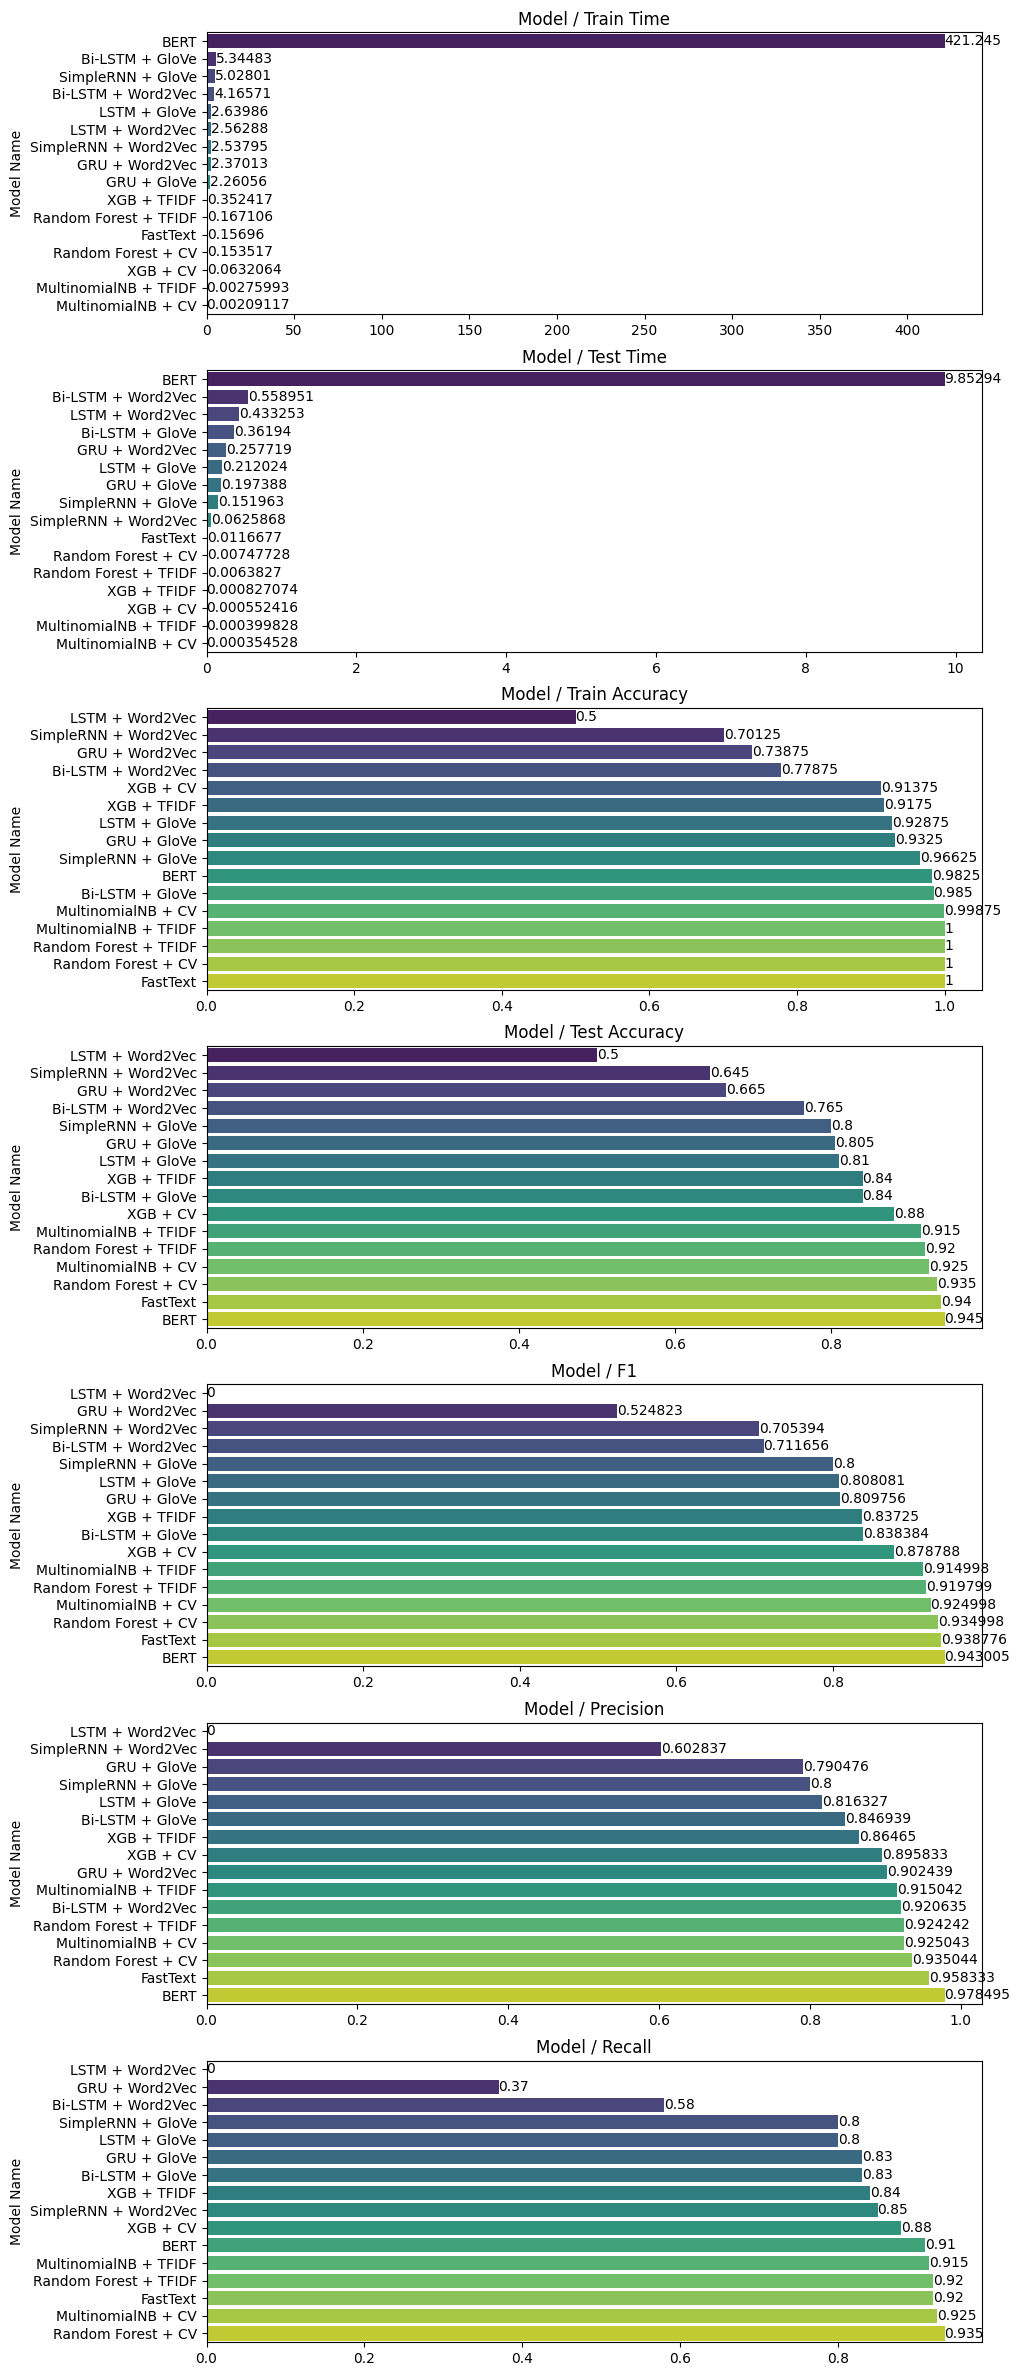

In [179]:
plot_results(scores_df, "Base Results")